In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.vector_ar.svar_model import SVAR

from scipy.stats import shapiro , kstest
from scipy.stats import chi2, binom, t, norm
from scipy.stats import multivariate_t, multivariate_normal
from scipy.stats import skew, kurtosis
from scipy.stats import gmean, hmean
from scipy.optimize import fsolve, minimize, minimize_scalar

from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.kalman_filter import KalmanFilter
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.irf import IRAnalysis
#from statsmodels.tsa.vector_ar.var_model import VAR

import arch

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import openpyxl
import xlsxwriter
from datetime import date, datetime

from sklearn.cluster import KMeans
from sklearn.linear_model import MultiTaskLasso, MultiTaskElasticNet, MultiTaskLassoCV, MultiTaskElasticNetCV, LinearRegression, Lasso, Ridge, LassoCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score, max_error
from sklearn.model_selection import cross_validate

import time
#from mpl_toolkits import mplot3d

from IPython.display import clear_output, display
#sns.color_palette("dark:#5A9_r", as_cmap=True)
sns.set_theme()#, palette="dark:#5A9_r")

# Function definitions

In [2]:
def call(x, k, n):
    if x < n:
        return k+(n-k)*np.exp((x-k)/(n-k) - 1)
    else:
        return x
        
def inv_call(y, k, n):
    if y < n:
        return n+(n-k)*np.log((y-k)/(n-k))
    else:
        return y

# compound return
def comp_prod(frame, periods):
    return ((1 + frame).rolling(window=periods).apply(np.prod) - 1).dropna()
    

# forecasting function w/ given shocks
def estimate(data, const, lags, lag, shocks=None, steps=1):
#def estimate(data, model, lag, shocks=None, steps=1):
    # input check
    if steps < 1:
        steps = 1
    if shocks is None:
        shocks = np.zeros((steps, data.shape[1]))

    # allocating memory
    preds = np.zeros((steps, data.shape[1]))
    #preds = np.vstack((data,np.zeros((steps, data.shape[1]))))
    regs = data[-lag:].copy()

    #print(preds)
    #print(regs)

    #preds = model.forecast(data, 1) + shocks[0]
    # forecast cycle
    for step in range(steps):
        #print(preds)
        I = np.einsum('ij, ijk -> k',regs[::-1], lags)
        #I = np.einsum('ij, ij -> j',regs[::-1], lags)
        regs[:-1] = regs[1:]
        regs[-1] = const + I + shocks[step]
        preds[step] = regs[-1]
        # preds = np.vstack([preds, model.forecast(np.vstack([data, preds]), 1) + shocks[step]])

    return preds

# simulation function
def simulation(data, shocks, model, horizons, kappa, eta, lag, train_size, i, sim_len, eval_size, eval_dates, sim_start,N):
    step = horizons.max()
    data = data[['g','shadow','Rf']].values[(train_size+i-lag):(train_size+i)]

    n_regs = data.shape[1] # number of regressors
    A = model.params[0] # array of constants
    B = model.params[1:].reshape((-1,n_regs,n_regs)) # array of lag matrices
    #print(np.abs(np.linalg.eig(model.params[1:]).eigenvalues))
    #B = np.einsum('jii -> ji', model.params[1:].reshape((-1,n_regs,n_regs)))
    # allocating memory for simulations
    r_temp = np.array([np.zeros(sim_len)]*len(horizons))
    tr_temp = np.array([np.zeros(sim_len)]*len(horizons))
    
    for sim in range((sim_start), (sim_start+sim_len)):
        # forecast w/ shocks
        fcst = estimate(data=data, const=A, lags=B, lag=lag, shocks=shocks[(i + sim*eval_size):(i+step+1 + sim*eval_size)], steps=step)
        #fcst = estimate(data=data, model=model, lag=lag, shocks=shocks[(i + sim*eval_size):(i+step+1 + sim*eval_size)], steps=step)
        #print(i, fcst)
        # create lagged forecasts with first value as last observation
        lfcst = np.roll(fcst, shift=1, axis=0)
        lfcst[0] = data[-1]
        # transform shadow values
        fcst[:,1] = np.array([call(fcst[j,1], k=kappa, n=eta) for j in range(step)], copy=True)
        lfcst[:,1] = np.array([call(lfcst[j,1], k=kappa, n=eta) for j in range(step)], copy=True)

        # calculate m COE
        fcst = np.column_stack((fcst,fcst[:,1] + np.exp(fcst[:,0]) - 1))
        lfcst = np.column_stack((lfcst,lfcst[:,1] + np.exp(lfcst[:,0])-1))

        # convert excess growth into short-term
        fcst[:,3] = fcst[:,3] + fcst[:,0]
        lfcst[:,3] = lfcst[:,3] + lfcst[:,0]
        # if any(lfcst[:,1] != oldf):
        #     print("call works")
        
        # calculate (total)returns
        if N > 0:
            r = np.exp(lfcst[:,3]) * (np.exp(fcst[:,3])/(fcst[:,4] - np.exp(fcst[:,3]) + 1) * (1 - (np.exp(fcst[:,3])/(1+fcst[:,4]))**N) \
                                    + np.exp(fcst[:,0])/(fcst[:,1]) * (np.exp(fcst[:,3])/(1+fcst[:,4]))**N) \
                                    * (np.exp(lfcst[:,3])/(lfcst[:,4] - np.exp(lfcst[:,3]) + 1) * (1 - (np.exp(lfcst[:,3])/(1+lfcst[:,4]))**N) \
                                    + np.exp(lfcst[:,0])/(lfcst[:,1]) * (np.exp(lfcst[:,3])/(1+lfcst[:,4]))**N)**(-1) - 1 - fcst[:,2]
            
            tr = np.exp(lfcst[:,3]) * (np.exp(fcst[:,3])/(fcst[:,4] - np.exp(fcst[:,3]) + 1) * (1 - (np.exp(fcst[:,3])/(1+fcst[:,4]))**N) \
                                    + np.exp(fcst[:,0])/(fcst[:,1]) * (np.exp(fcst[:,3])/(1+fcst[:,4]))**N) \
                                    * (np.exp(lfcst[:,3])/(lfcst[:,4] - np.exp(lfcst[:,3]) + 1) * (1 - (np.exp(lfcst[:,3])/(1+lfcst[:,4]))**N) \
                                    + np.exp(lfcst[:,0])/(lfcst[:,1]) * (np.exp(lfcst[:,3])/(1+lfcst[:,4]))**N)**(-1) - 1 \
                                    + (np.exp(lfcst[:,3])/(lfcst[:,4] - np.exp(lfcst[:,3])+1) * (1 - (np.exp(lfcst[:,3])/(1+lfcst[:,4]))**N) \
                                    + np.exp(lfcst[:,0])/(lfcst[:,1]) * (np.exp(lfcst[:,3])/(1+lfcst[:,4]))**N)**(-1) - fcst[:,2]
        else:
            r = (np.exp(fcst[:,0])*lfcst[:,1])/(fcst[:,1]) - 1 - fcst[:,2]
            tr = (np.exp(fcst[:,0])*lfcst[:,1])/(fcst[:,1]) - 1 + lfcst[:,1] - fcst[:,2]  # r + dividend yield
        
        #print(sim, r)
        # take cumulative products
        cr = (1 + r).cumprod(axis=0) - 1 # array([r1, r2, r3, ...])
        ctr = (1 + tr).cumprod(axis=0) - 1
        #print(sim, cr)

        #print(cr)
        # copy forecasts to frames
        for h in range(len(horizons)):
            r_temp[h,sim-sim_start] = cr[horizons[h]-1]
            tr_temp[h,sim-sim_start] = ctr[horizons[h]-1]
            # r_temp[h,sim-sim_start] = (1+r[:horizons[h]]).prod() -1
            # tr_temp[h,sim-sim_start] = (1+tr[:horizons[h]]).prod() -1
        #print(sim, r_temp)

    #print(i, r_temp[0].max())
    return r_temp, tr_temp

def vol_diff(data, pct):
    kappa = data.min()*.8
    eta = data.quantile(pct)

    # data['m-g'].apply(inv_call, k=kappa, n=eta)
    top = data.loc[data >= eta].std()
    bottom = data.loc[data < eta].apply(inv_call, k=kappa, n=eta).std()

    return abs(top-bottom)

def vol_ratio(data, pct):
    kappa = data.min()*.8
    eta = data.quantile(pct)

    # data['m-g'].apply(inv_call, k=kappa, n=eta)
    top = data.loc[data >= eta].std()
    bottom = data.loc[data < eta].apply(inv_call, k=kappa, n=eta).std()

    return abs(top/bottom - 1)

# Data processing

In [3]:
# GDP ir CPI
op_long = pd.read_excel("output_long.xlsx", sheet_name="data", usecols=['Date','GDP','CPI'], index_col=[0])
op_long.index = pd.to_datetime(op_long.index)

add_ind = op_long.shift(1).dropna()/100 # percentages
add_ind = add_ind[add_ind.index >= '1990-01-31'].iloc[:-1]

In [4]:
add_ind

,GDP,CPI
Date,,
1990-02-05,0.029000,0.047767
1990-03-05,0.017727,0.042488
1990-04-02,0.018349,0.043710
1990-05-01,0.020417,0.044763
1990-06-04,0.020348,0.045780
...,...,...
2023-10-09,0.011848,0.029324
2023-11-06,0.011849,0.028993
2023-12-04,0.009925,0.028477


In [5]:
inds = add_ind[['GDP','CPI']].values

In [1]:
# for i in range(12):
#     add_ind[f"GDP{i+1}"] = add_ind["GDP"].shift(i+1)
#     add_ind[f"CPI{i+1}"] = add_ind["CPI"].shift(i+1)

# exog_corrs = add_ind[[f'GDP{i+1}' for i in range(12)] + [f'CPI{i+1}' for i in range(12)]].corr().iloc[0:12,12:24]
# print(exog_corrs.to_latex())

In [6]:
# Pastumiame 6 mėn. 
add_ind["GDP"] = add_ind["GDP"].shift(6)
add_ind["CPI"] = add_ind["CPI"].shift(4)

# add_ind["GDP9"] = add_ind["GDP"].shift(9)
# add_ind["CPI9"] = add_ind["CPI"].shift(9)

In [7]:
add_ind

,GDP,CPI
Date,,
1990-02-05,NaN,NaN
1990-03-05,NaN,NaN
1990-04-02,NaN,NaN
1990-05-01,NaN,NaN
1990-06-04,NaN,0.047767
...,...,...
2023-10-09,0.009828,0.035309
2023-11-06,0.010075,0.033534
2023-12-04,0.007437,0.032095


<Axes: title={'center': 'Exogenous variables'}, xlabel='Date'>

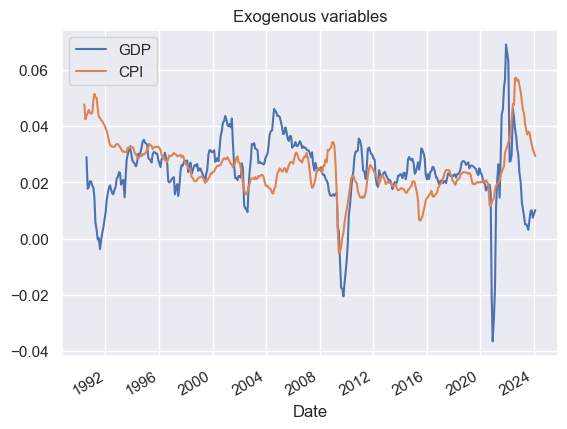

In [8]:
add_ind.plot(title='Exogenous variables')

In [7]:
#data = pd.read_excel("AkcijuDuomen.xlsx", sheet_name="data", usecols=["Date","P", "Rf", "D"], index_col=[0], parse_dates=[0]).dropna()
data = pd.read_excel("mxusdata.xlsx", sheet_name="data", usecols=['Date','P','D','Rf']
                     ,index_col=[0], parse_dates=[0]).dropna()
data.index = pd.date_range(start = data.index[0], freq="ME", periods = data.shape[0]) # month-end dates for df index
data = data.iloc[1:]

In [8]:
for col in data.columns:
    data[col] = pd.to_numeric(data[col])

In [9]:
data

,P,D,Rf
1990-02-28,311.987324,11.090655,0.006043
1990-03-31,319.554584,11.156392,0.006500
1990-04-30,310.962689,11.203346,0.006708
1990-05-31,339.567872,11.147001,0.006674
1990-06-30,336.550368,11.193955,0.006235
...,...,...,...
2023-10-31,3985.590000,64.520000,0.004738
2023-11-30,4352.860000,65.150000,0.004375
2023-12-31,4552.010000,66.170000,0.004189
2024-01-31,4618.900000,66.450000,0.004785


In [10]:
data.shape, add_ind.shape

((409, 3), (409, 2))

In [11]:
f'Shapes match: {data.shape[0] == add_ind.shape[0]}'

'Shapes match: True'

In [12]:
data["D"] = data["D"]/12 # menesiniai dividendai

In [13]:
data["lnD"] = data["D"].apply(np.log) # log dividendai

In [14]:
data["d"] = data["lnD"].shift(-1) - data["lnD"] # men dividendu augimas

In [15]:
data

,P,D,Rf,lnD,d
1990-02-28,311.987324,0.924221,0.006043,-0.078804,0.005910
1990-03-31,319.554584,0.929699,0.006500,-0.072894,0.004200
1990-04-30,310.962689,0.933612,0.006708,-0.068694,-0.005042
1990-05-31,339.567872,0.928917,0.006674,-0.073736,0.004203
1990-06-30,336.550368,0.932830,0.006235,-0.069533,0.004186
...,...,...,...,...,...
2023-10-31,3985.590000,5.376667,0.004738,1.682069,0.009717
2023-11-30,4352.860000,5.429167,0.004375,1.691786,0.015535
2023-12-31,4552.010000,5.514167,0.004189,1.707321,0.004223
2024-01-31,4618.900000,5.537500,0.004785,1.711543,0.002555


# Returns

In [17]:
data["r"] = data["P"]/data["P"].shift(1) - 1 - data["Rf"] # price return
data["tr"] = data["P"]/data["P"].shift(1) - 1 + data["D"]/data["P"].shift(1) - data["Rf"] # total return
#(1+data["g"])*(data["m-g"].shift(1))/data["m-g"] + data["m-g"].shift(1) - 1

In [18]:
add_ind.index = data.index

In [19]:
data = pd.concat([data, add_ind], axis=1).dropna()

In [118]:
print(data.tail(10).to_latex())

\begin{tabular}{lrrrrrrrrr}
\toprule
 & P & D & Rf & lnD & d & r & tr & GDP & CPI \\
\midrule
2023-04-30 00:00:00 & 3950.690000 & 5.378333 & 0.003850 & 1.682379 & 0.001858 & 0.007902 & 0.009280 & 0.007941 & 0.044623 \\
2023-05-31 00:00:00 & 3969.210000 & 5.388333 & 0.004822 & 1.684236 & -0.000774 & -0.000134 & 0.001230 & 0.005062 & 0.040746 \\
2023-06-30 00:00:00 & 4228.590000 & 5.384167 & 0.004308 & 1.683463 & -0.003566 & 0.061040 & 0.062396 & 0.005086 & 0.038446 \\
2023-07-31 00:00:00 & 4370.100000 & 5.365000 & 0.004547 & 1.679896 & 0.003411 & 0.028918 & 0.030187 & 0.004307 & 0.037055 \\
2023-08-31 00:00:00 & 4288.810000 & 5.383333 & 0.004581 & 1.683308 & -0.003877 & -0.023183 & -0.021951 & 0.003136 & 0.038070 \\
2023-09-30 00:00:00 & 4083.330000 & 5.362500 & 0.004286 & 1.679430 & 0.002638 & -0.052196 & -0.050946 & 0.007260 & 0.037624 \\
2023-10-31 00:00:00 & 3985.590000 & 5.376667 & 0.004738 & 1.682069 & 0.009717 & -0.028674 & -0.027357 & 0.009828 & 0.035309 \\
2023-11-30 00:00:00 &

In [139]:
# VAR(data[['d','GDP','CPI']]).fit(ic='bic').summary()

In [2]:
# fig, ax = plt.subplots(4,3, figsize=(12,10))
# for i in range(4):
#     for j in range(3):
#         ax[i,j].scatter(data[f'GDP{3*i+j+1}'],data['d'])
#         m, b = np.polyfit(data[f'GDP{3*i+j+1}'], data['d'], 1)
#         ax[i,j].plot(data['d'], m*data['d']+b, color='red')
#         ax[i,j].title.set_text(f'GDP{3*i+j+1}')
        

# plt.tight_layout()
# plt.savefig('gdpscatter.png')
# plt.show()

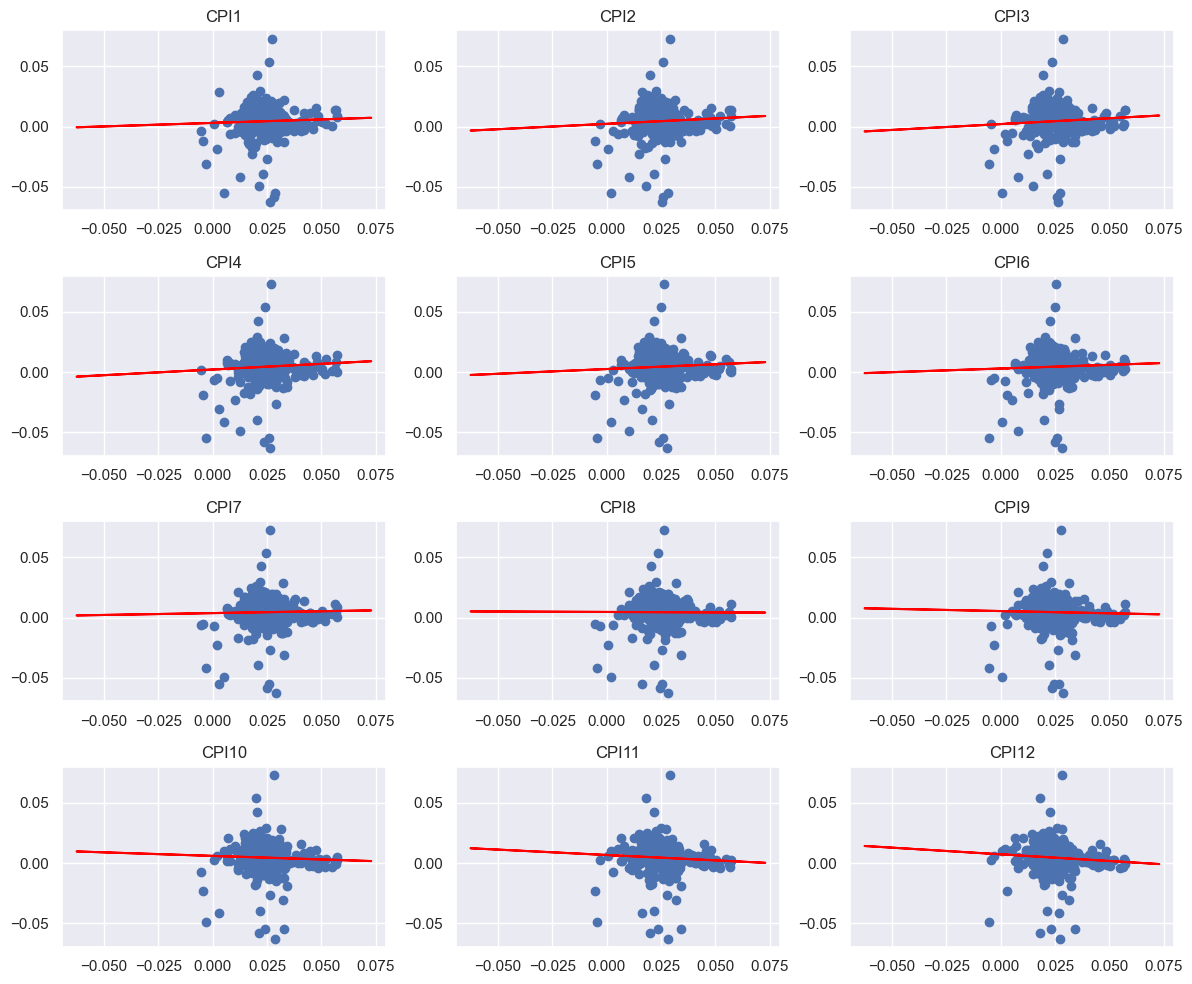

In [220]:
fig, ax = plt.subplots(4,3, figsize=(12,10))
for i in range(4):
    for j in range(3):
        ax[i,j].scatter(data[f'CPI{3*i+j+1}'],data['d'])
        m, b = np.polyfit(data[f'CPI{3*i+j+1}'], data['d'], 1)
        ax[i,j].plot(data['d'], m*data['d']+b, color='red')
        ax[i,j].title.set_text(f'CPI{3*i+j+1}')

plt.tight_layout()
plt.savefig('cpiscatter.png')
plt.show()

In [24]:
data.shape

(402, 10)

In [25]:
(1 + data['d']).prod()**(1/len(data)) - 1

0.004368995381631047

In [26]:
pd.DataFrame([(1 + data['d']).prod()**(1/len(data))]*len(data))

,0
0,1.004369
1,1.004369
2,1.004369
3,1.004369
4,1.004369
...,...
397,1.004369
398,1.004369
399,1.004369
400,1.004369


In [183]:
data

,P,D,Rf,lnD,d,r,tr,GDP,CPI,Y10
1990-08-31,303.216822,0.932047,0.006364,-0.070372,0.001678,-0.100678,-0.097894,0.029000,0.043710,0.083625
1990-09-30,287.696889,0.933612,0.005553,-0.068694,-0.002518,-0.056738,-0.053659,0.017727,0.044763,0.082477
1990-10-31,285.769823,0.931264,0.006517,-0.071212,0.007535,-0.013216,-0.009979,0.018349,0.045780,0.083354
1990-11-30,302.897211,0.938308,0.005850,-0.063677,0.004161,0.054084,0.057368,0.020417,0.044761,0.083619
1990-12-31,310.417470,0.942221,0.005546,-0.059516,-0.000831,0.019282,0.022393,0.020348,0.044506,0.082682
...,...,...,...,...,...,...,...,...,...,...
2023-09-30,4083.330000,5.362500,0.004286,1.679430,0.002638,-0.052196,-0.050946,0.007260,0.037624,0.034918
2023-10-31,3985.590000,5.376667,0.004738,1.682069,0.009717,-0.028674,-0.027357,0.009828,0.035309,0.036282
2023-11-30,4352.860000,5.429167,0.004375,1.691786,0.015535,0.087774,0.089137,0.010075,0.033534,0.039280
2023-12-31,4552.010000,5.514167,0.004189,1.707321,0.004223,0.041563,0.042829,0.007437,0.032095,0.041453


<Axes: >

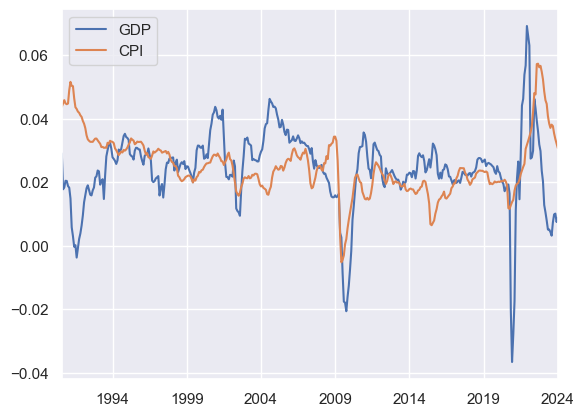

In [188]:
data[['GDP','CPI']].plot()

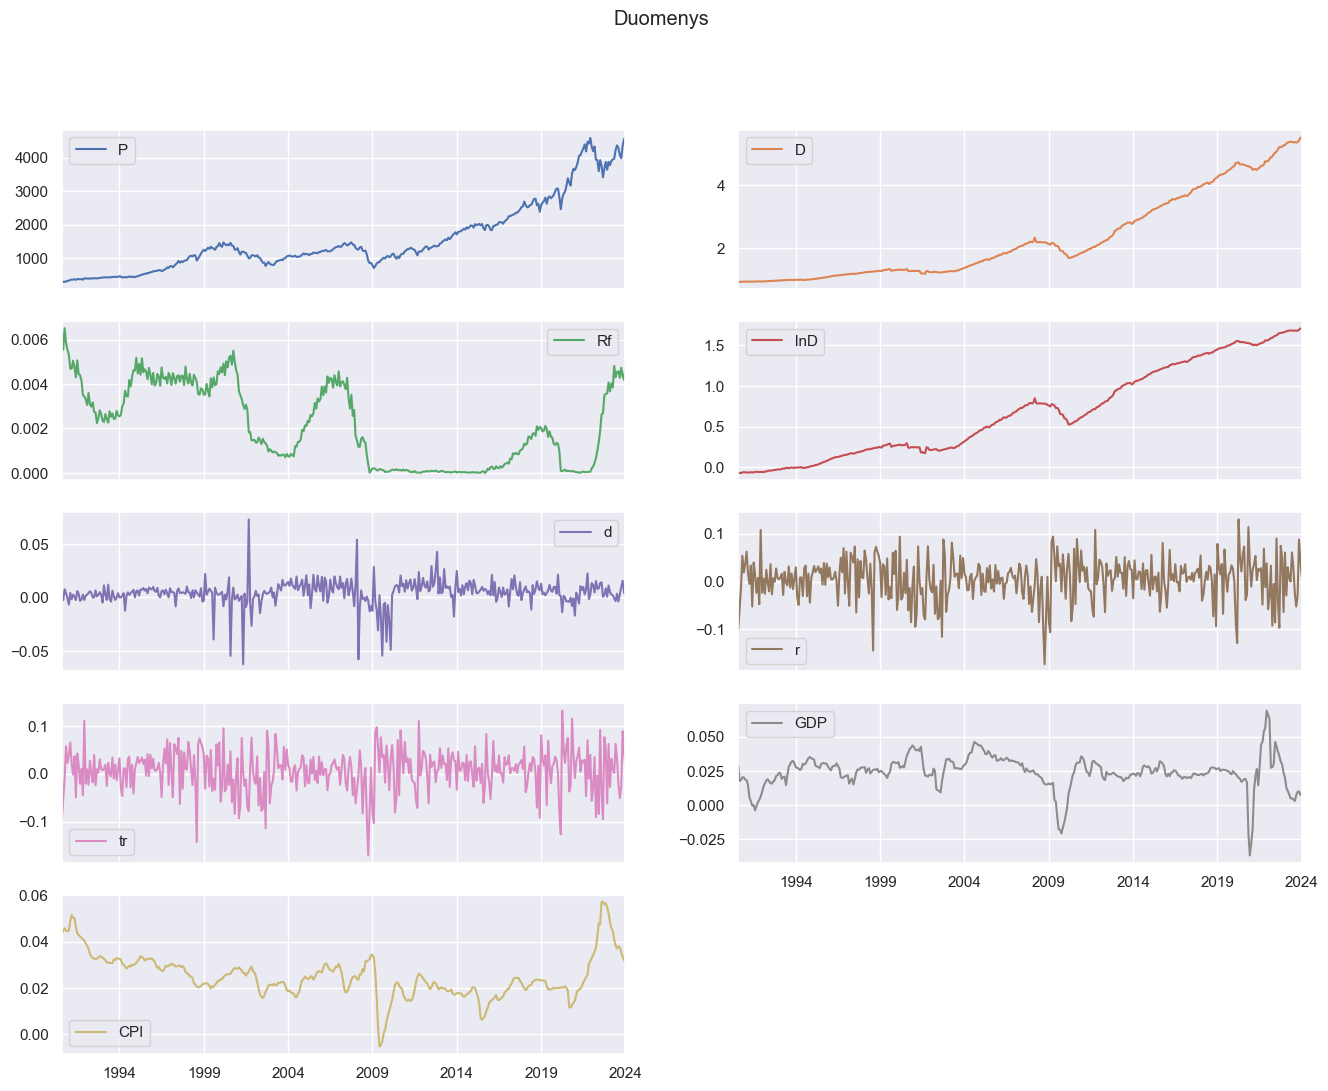

In [83]:
data.plot(subplots=True, figsize=(16,12), layout=(5,2), title='Duomenys')
plt.savefig('dataplots.png')

In [237]:
gdpmax

0.2916267319196957

In [24]:
cpicors

CPI1     0.043133
CPI2     0.066963
CPI3     0.073612
CPI4     0.072159
CPI5     0.060441
CPI6     0.047151
CPI7     0.023893
CPI8    -0.005709
CPI9    -0.028861
CPI10   -0.046237
CPI11   -0.070090
CPI12   -0.087533
Name: d, dtype: float64

In [23]:
gdpcors = (data[['d'] + [f'GDP{l+1}' for l in range(12)]].corr()['d'].iloc[1:])
cpicors = (data[['d'] + [f'CPI{l+1}' for l in range(12)]].corr()['d'].iloc[1:])

In [253]:
print(cpicors.to_latex())

\begin{tabular}{lr}
\toprule
 & d \\
\midrule
CPI1 & 0.043133 \\
CPI2 & 0.066963 \\
CPI3 & 0.073612 \\
CPI4 & 0.072159 \\
CPI5 & 0.060441 \\
CPI6 & 0.047151 \\
CPI7 & 0.023893 \\
CPI8 & -0.005709 \\
CPI9 & -0.028861 \\
CPI10 & -0.046237 \\
CPI11 & -0.070090 \\
CPI12 & -0.087533 \\
\bottomrule
\end{tabular}



# Long-term dividend growth

## Lasso

In [54]:
data[['d','GDP','CPI']].iloc[:-1].values.shape

(401, 3)

In [55]:
scaler = StandardScaler()
scaler.fit(data[['d','GDP','CPI']].iloc[:-1].values)

StandardScaler()

In [56]:
# X = scaler.transform(np.hstack([data[['d']].iloc[:-1].values, data[['GDP','CPI']].shift(6).iloc[:-1].values]))[6:]
# #regs.columns = ['d0','GDP0','CPI0']

# y = scaler.transform(np.hstack([data[['d']].shift(-1).iloc[:-1].values, data[['GDP','CPI']].shift(5).iloc[:-1].values]))[6:]

X = scaler.transform(data[['d','GDP','CPI']].iloc[:-1].values)

y = scaler.transform(data[['d','GDP','CPI']].shift(-1).iloc[:].dropna().values)
y.shape, X.shape

# y_d = y[:,0]
# y_g = y[:,1]
# y_c = y[:,2]
#feats.columns = ['d1','GDP1','CPI1']

#train_data = pd.concat([regs, feats], axis=1).dropna()

((401, 3), (401, 3))

In [518]:
data[['d','GDP','CPI']]

,d,GDP,CPI
1990-08-31,0.001678,0.029000,0.043710
1990-09-30,-0.002518,0.017727,0.044763
1990-10-31,0.007535,0.018349,0.045780
1990-11-30,0.004161,0.020417,0.044761
1990-12-31,-0.000831,0.020348,0.044506
...,...,...,...
2023-09-30,0.002638,0.007260,0.037624
2023-10-31,0.009717,0.009828,0.035309
2023-11-30,0.015535,0.010075,0.033534
2023-12-31,0.004223,0.007437,0.032095


In [57]:
np.arange(0.1,1,0.01)

array([0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ,
       0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31,
       0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42,
       0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53,
       0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64,
       0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75,
       0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86,
       0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97,
       0.98, 0.99])

In [73]:
#model = MultiTaskLassoCV(alphas=np.arange(0.1,1,0.01),cv=10)
model = MultiTaskLasso(alpha=0.5)
model.fit(X[:], y[:])

MultiTaskLasso(alpha=0.5)

In [58]:
folds = 10
scores = np.zeros((len(np.arange(0.1,1,0.01)), folds))

scoring= 'neg_mean_absolute_percentage_error' #'neg_mean_squared_error'

i = 0
for alpha in np.arange(0.1,1,0.01):
    model = MultiTaskLasso(alpha=alpha)
    scores[i] = cross_validate(model, X, y, cv=folds, scoring=scoring)['test_score']
    i += 1

In [59]:
scores = pd.DataFrame(scores, index=np.arange(0.1,1,0.01).round(2))

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

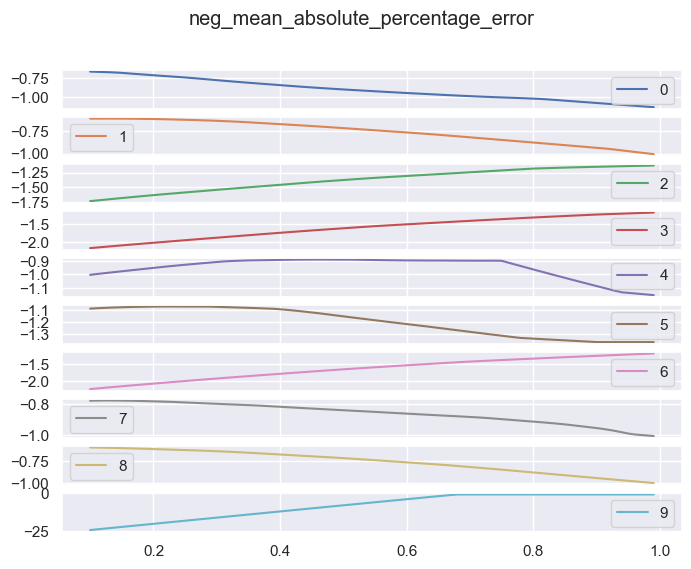

In [61]:
scores.plot(subplots=True, figsize=(8,6), title=scoring)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

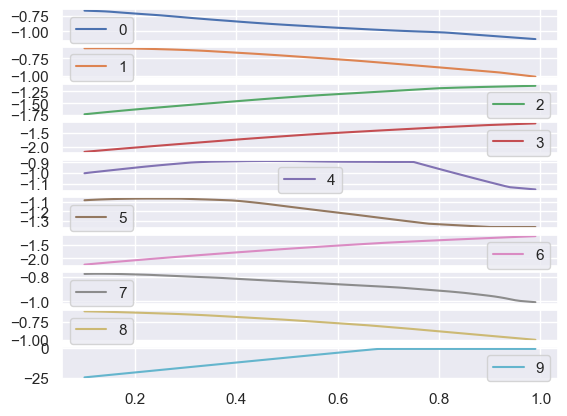

In [652]:
scores.plot(subplots=True)

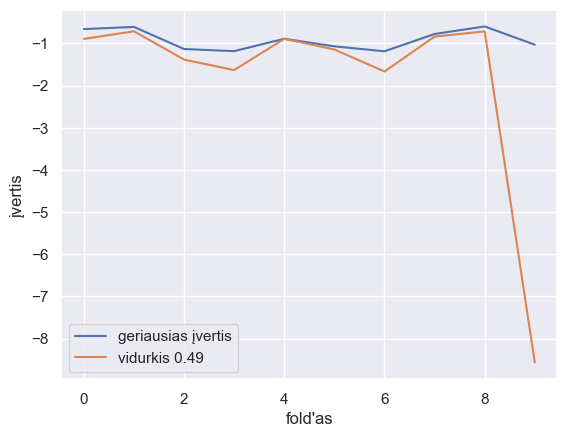

In [70]:
scores.max(axis=0).plot()
scores.loc[np.mean(scores.idxmax(axis=0)).round(2)].plot()
plt.ylabel('įvertis')
plt.xlabel('fold\'as')
plt.legend(['geriausias įvertis', f'vidurkis {np.mean(scores.idxmax(axis=0)).round(2)}'])
plt.savefig('regscores.png')

In [654]:
scores.index

Index([ 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19,  0.2, 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29,  0.3, 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39,  0.4, 0.41, 0.42, 0.43, 0.44, 0.45,
       0.46, 0.47, 0.48, 0.49,  0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57,
       0.58, 0.59,  0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69,
        0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79,  0.8, 0.81,
       0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89,  0.9, 0.91, 0.92, 0.93,
       0.94, 0.95, 0.96, 0.97, 0.98, 0.99],
      dtype='float64')

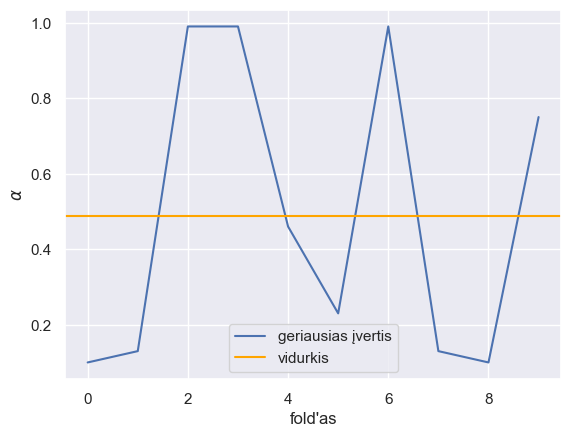

In [69]:
scores.idxmax(axis=0).plot()
plt.axhline(np.mean(scores.idxmax(axis=0)), color='orange')
plt.xlabel('fold\'as')
plt.ylabel(r'$\alpha$')
plt.legend(['geriausias įvertis', 'vidurkis'])
plt.savefig('regalphas.png')

In [29]:
model = VAR(data[['d','GDP','CPI']].iloc[:230]).fit(1)
A = model.params.values[0]
B = model.params.values[1:]
A,B

(array([-0.00890643, -0.00089649, -0.00087736]),
 array([[-0.034298  , -0.00723181, -0.00393961],
        [ 0.29913744,  1.00254535,  0.02928459],
        [ 0.16101188,  0.02359945,  0.9979587 ]]))

In [533]:
pd.DataFrame(np.linalg.eig(B).eigenvalues, columns=['eig']).apply(np.abs)

,eig
0,0.000000
1,0.811931
2,0.826834


In [74]:
B = model.coef_
A = model.intercept_
A,B.T

(array([ 0.00018525, -0.00423227, -0.00347117]),
 array([[0.        , 0.        , 0.        ],
        [0.13190451, 0.45021063, 0.03751699],
        [0.01617945, 0.02081542, 0.4735903 ]]))

In [1285]:
pd.DataFrame(np.linalg.eig(B).eigenvalues, columns=['eig']).apply(np.abs)

,eig
0,0.020843
1,1.007923
2,0.962529


In [520]:
y_pred = scaler.inverse_transform(model.predict(data[['d','GDP','CPI']].iloc[230:].values))

In [521]:
model.predict(data[['d','GDP','CPI']].iloc[230:231].values)

array([[0.48409314, 0.1054296 , 0.07516582]])

In [464]:
data['d'].std()*2*24**.5

0.11570087176388033

In [461]:
model.dual_gap_(alpha=[0.95, 0.05])

TypeError: 'float' object is not callable

In [566]:
A + B @ data[['d','GDP','CPI']].iloc[230].values

array([-0.00649356, -0.01181009, -0.01566465])

In [567]:
np.linalg.inv(np.eye(3) - B) @ A

array([ 0.07409528,  0.39539036, -0.31097452])

In [75]:
y_pred = np.zeros((60,3))
y_pred[0] = A + B @ scaler.transform([data[['d','GDP','CPI']].iloc[229].values])[0]
for i in range(1,60):
    y_pred[i] = A + B @ y_pred[i-1]

y_pred = scaler.inverse_transform(y_pred)

In [31]:
y_pred = np.zeros((60,3))
y_pred[0] = A + B @ data[['d','GDP','CPI']].iloc[229].values
for i in range(1,60):
    y_pred[i] = A + y_pred[i-1] @ B

<Axes: >

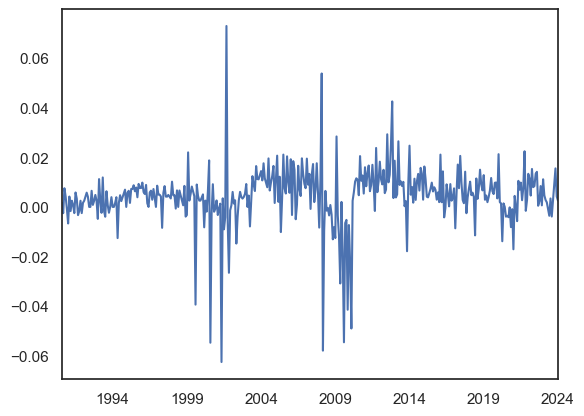

In [534]:
data['d'].plot()

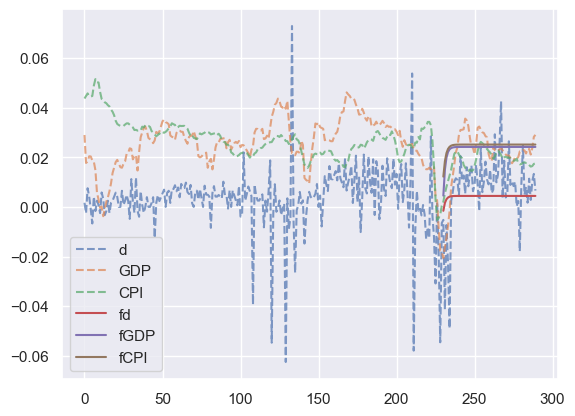

In [76]:
plt.plot(np.vstack([data[['d','GDP','CPI']].values[:230],data[['d','GDP','CPI']].values[230:230+60]]), ls='--', alpha=.7)
plt.plot(range(230,230+60),y_pred)
#plt.plot(data[['d','GDP','CPI']].values[230:230+120])
plt.legend(['d','GDP','CPI','fd','fGDP','fCPI'])
plt.savefig('statfor.png')
plt.show()

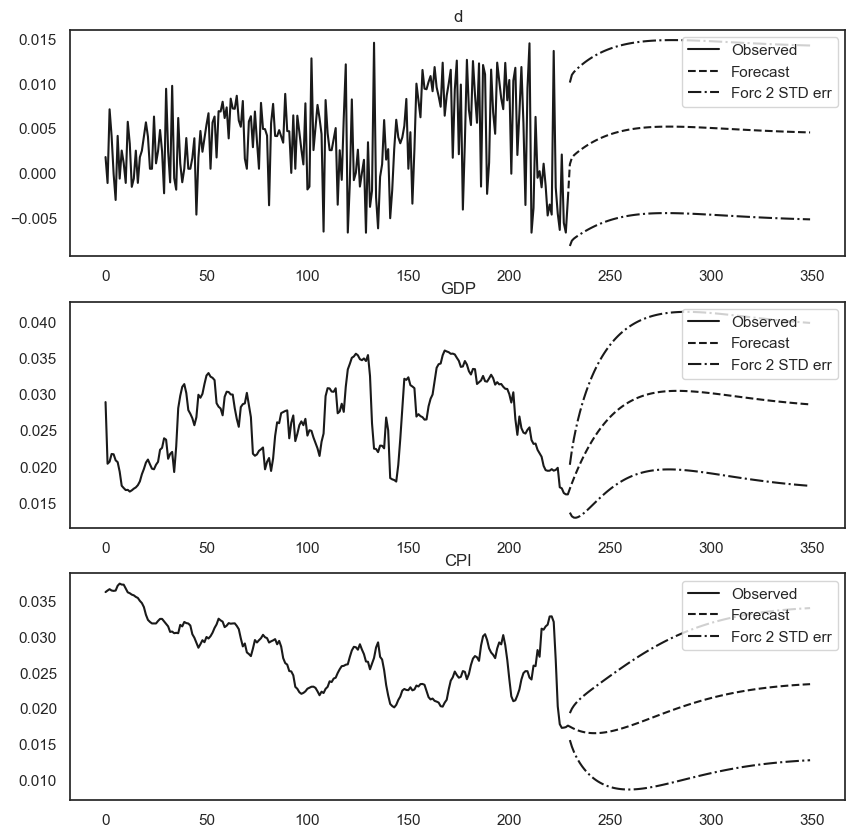

In [224]:
_ = model.plot_forecast(120)

In [216]:
model.is_stable()

True

## Augančio lango div

In [20]:
N = 24 # short-term growth window

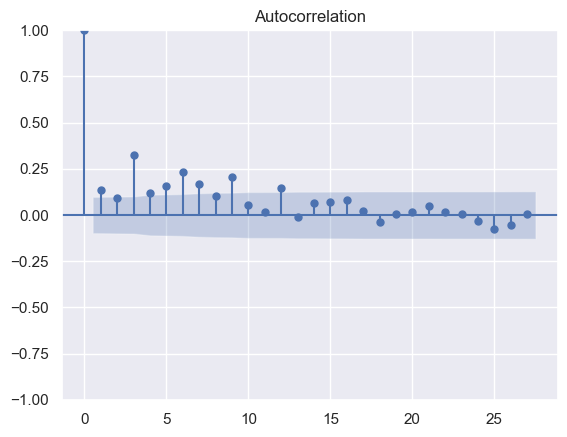

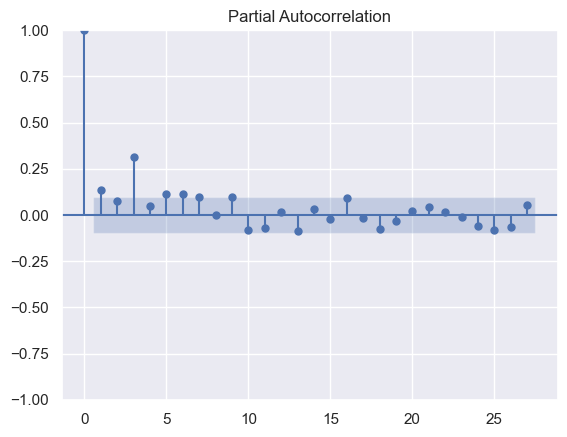

In [25]:
dacf = plot_acf(data['d'])
dpacf = plot_pacf(data['d'])

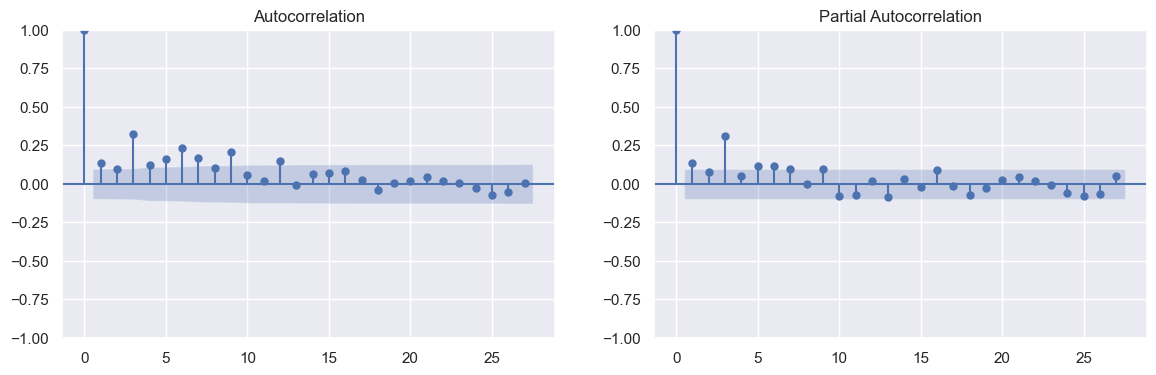

In [196]:
fig, ax = plt.subplots(1,2, figsize=(14,4))
plot_acf(data['d'], ax=ax[0])
plot_pacf(data['d'], ax=ax[1])
plt.savefig('acfd.png')
plt.show()

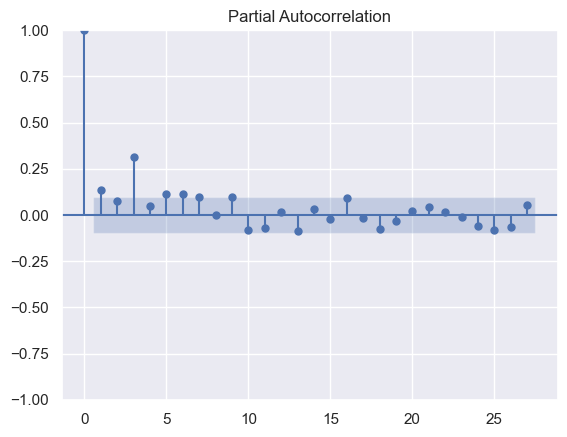

In [181]:
_ = plot_pacf(data['d'])
plt.savefig('pacfd.png')

In [21]:
%%time
long_div = np.zeros(data.shape[0])
short_div = np.zeros(data.shape[0])


ars = np.zeros(data.shape[0])
sigmas = np.zeros(data.shape[0])
#data["g"] = np.zeros(data.shape[0])

#constr = {'L1.d.GDP6': 0, 'L1.d.CPI6': 0} # dont let d influence exog
# constr = {'L1.d.d':fparams[0,0],'L1.GDP.d':fparams[1,0],'L1.CPI.d':fparams[2,0],
#           'L1.d.GDP':fparams[0,1],'L1.GDP.GDP':fparams[1,1],'L1.CPI.GDP':fparams[2,1],
#           'L1.d.CPI':fparams[0,2],'L1.GDP.CPI':fparams[1,2],'L1.CPI.CPI':fparams[2,2]}

l = data[data.index >= '2000-08-31'].shape[0] # '1970-01-01' for old data
eigens = np.zeros((l,3))


alphas = np.zeros(l)
ratios = np.zeros(l)
eigs = np.zeros(l)
pars = np.zeros((l,3,3))


alph = 10**-3
for i in range(l):
    # Lasso/MTL

    # standard scaling
    # scaler = StandardScaler()
    # scaler.fit(data[['d','GDP','CPI']].values[0:120+i])

    # X = scaler.transform(data[['d','GDP','CPI']].iloc[0:119+i].values)
    # y = scaler.transform(data[['d','GDP','CPI']].iloc[0:120+i].shift(-1).dropna().values)

    # model = MultiTaskLasso(alpha=0.5)
    # model.fit(X,y)
    
    # A, B = model.intercept_, model.coef_
    # if N > 0:
    #     preds = np.zeros((N,3))
    #     #preds[0] = A + B @ scaler.transform([data[['d','GDP','CPI']].iloc[119+i].values])[0]
    #     preds[0] = A + B @ scaler.transform([np.hstack([data['d'].values[119+i],
    #                                                    inds[119+i,0], inds[119+i+2,1]])])[0]
    #     preds[0,[1,2]] = scaler.transform([np.hstack([0,inds[119+i+1,0], inds[119+i+2+1,1]])])[0,[1,2]]
    #     for j in range(1,4):
    #         preds[j] = A + B @ preds[j-1]
    #         preds[j,[1,2]] = scaler.transform([np.hstack([0,inds[119+i+j+1,0], inds[119+i+2+j+1,1]])])[0,[1,2]]
    #     for j in range(4,6):
    #         preds[j] = A + B @ preds[j-1]
    #         preds[j,1] = scaler.transform([np.hstack([0,inds[119+i+j+1,0], inds[119+i+2+j+1,1]])])[0,1]
    #     for j in range(6,N):
    #         #print(preds)
    #         preds[j] = A + B @ preds[j-1]
    
    #     preds = scaler.inverse_transform(preds)
        
    #     short_div[120+i] = preds[:,0].mean()
    # long_div[120+i] = scaler.inverse_transform([np.linalg.inv(np.eye(3) - B) @ A])[0,0]

    # eigens[i,:] = np.linalg.eig(B).eigenvalues

    # pars[i] = B
    # print(pars[i,:])

    # alphas[i] = alph

    
    #alphas[i] = model.alpha_
    #ratios[i] = model.l1_ratio_
    
    # AR1
    # mod = ARIMA(data['d'].iloc[0:120+i], order=(1,0,0)) # growing window
    # res = mod.fit()
    
    # long_div[120+i] = res.params["const"] # rescaling done to avoid convergence errors
    # if N > 0:
    #     short_div[120+i] = res.forecast(N).values.mean()

    # eigs[i] = res.params['ar.L1']
    
    # VARMAX (fixuojami param. bet letas fit)
    # varmod = VAR(data[['d','GDP','CPI']].iloc[0:120+i]).fit(1)
    # mod = VARMAX(data[['d','GDP','CPI']].iloc[0:120+i], order=(1,0,0))
    # evec.iloc[i] = varmod.params.iloc[1:].values.reshape(9)
    # #fparams = np.mean(evec[:i+1,:], axis=0).reshape((3,3))
    # fparams = evec.iloc[:i+1].ewm(halflife=36).mean().values[-1].reshape((3,3))
    # #fparams = np.linalg.inv(np.linalg.eig(varmod.params.iloc[1:].values).eigenvectors) @ fscale @ np.linalg.inv(np.linalg.eig(varmod.params.iloc[1:].values).eigenvectors)
    # constr = {'L1.d.d':fparams[0,0],'L1.GDP.d':fparams[1,0],'L1.CPI.d':fparams[2,0],
    #       'L1.d.GDP':fparams[0,1],'L1.GDP.GDP':fparams[1,1],'L1.CPI.GDP':fparams[2,1],
    #       'L1.d.CPI':fparams[0,2],'L1.GDP.CPI':fparams[1,2],'L1.CPI.CPI':fparams[2,2]}
    # res = mod.fit_constrained(constr, maxiter=1000)
    # A = res.params.iloc[0:3].values
    # B = res.params.iloc[3:12].values.reshape(3,3)

    # eigens[i,:] =  np.abs(np.linalg.eig(B).eigenvalues)
    
    # eq = np.linalg.inv(np.eye(3) - B) @ A
    # long_div[120+i] = eq[0]
    # short_div[120+i] = res.forecast(N).values[:,0].mean()

    # VAR
    mod = VAR(data[['d','GDP','CPI']].iloc[0:120+i])
    res = mod.fit(1)
    #eq = res.params.iloc[0].values @ np.linalg.inv(np.eye(3) - res.params.iloc[1:].values)
    
    long_div[120+i] = res.intercept_longrun()[0]


    A, B = res.params.iloc[0].values, res.params.iloc[1:].values
    preds = np.zeros((N,3))
    
    preds[0] = A + np.hstack([data['d'].values[119+i],
                                  inds[119+i,0], inds[119+i+2,1]]) @ B
    preds[0,[1,2]] = np.hstack([0,inds[119+i+1,0], inds[119+i+2+1,1]])[[1,2]]
    for j in range(1,4):
        preds[j] = A + preds[j-1] @ B
        preds[j,[1,2]] = np.hstack([0,inds[119+i+j+1,0], inds[119+i+2+j+1,1]])[[1,2]]
    for j in range(4,6):
        preds[j] = A + preds[j-1] @ B
        preds[j,1] = np.hstack([0,inds[119+i+j+1,0], inds[119+i+2+j+1,1]])[1]
    for j in range(6,N):
        #print(preds)
        preds[j] = A + preds[j-1] @ B

        
    short_div[120+i] = preds[:,0].mean()
    eigens[i,:] = np.linalg.eig(B).eigenvalues

    
    #eigens[i,:] =  np.linalg.svd(res.params.iloc[1:].values)[1]
    #eigens[i,:] =  np.linalg.eig(res.params.iloc[1:].values).eigenvalues
    # evec[i,:] = np.linalg.eig(res.params.iloc[1:].values).eigenvectors.reshape((9))
    #evec[i,:] = res.params.iloc[1:].values.reshape(9)

    # MAR1
    # mod = MarkovAutoregression(data['d'][0:120+i]*100, k_regimes=regimes, order=1,
    #                        switching_variance=True, switching_ar=False)
    # res = mod.fit(maxiter=1000)
    # durations = attention(res.expected_durations, 0.1)
    # weights = durations/durations.sum()
    
    # long_div[120+i] = np.array([res.params[f'const[{r}]'] for r in range(regimes)]).dot(
    #     weights)/100
    # model = ES(data['d'].iloc[0:120+i]*100).fit()
    # long_div[120+i] = model.forecast().iloc[0]/100
    clear_output(wait=True)
    print(f'{i+1}/{l}')

data["g"] = long_div # long-term growth
data["g1"] = short_div # short_term growth
del long_div, short_div

282/282
CPU times: total: 859 ms
Wall time: 2.33 s


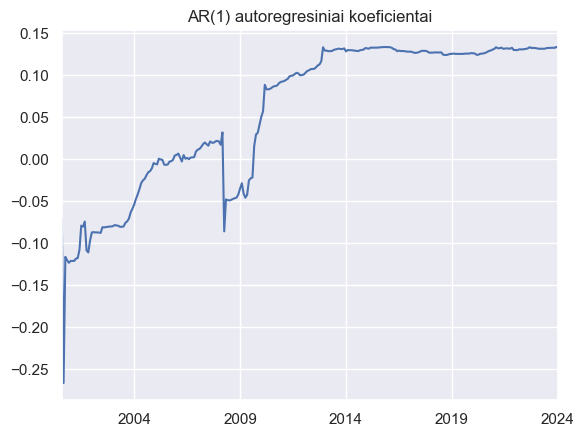

In [117]:
eigs = pd.DataFrame(eigs, index=data.index[120:])
eigs.plot(title='AR(1) autoregresiniai koeficientai', legend=0)
plt.savefig('arcoefs.png')

In [705]:
eigens.describe()

,0,1,2
count,282.0,282.000000,282.000000
mean,0.0,0.403767,0.504024
std,0.0,0.098830,0.047405
min,0.0,0.227185,0.454499
25%,0.0,0.293558,0.458584
50%,0.0,0.429429,0.495153
75%,0.0,0.494397,0.559616
max,0.0,0.505324,0.576140


In [1316]:
# evec = pd.DataFrame(evec)
# evec

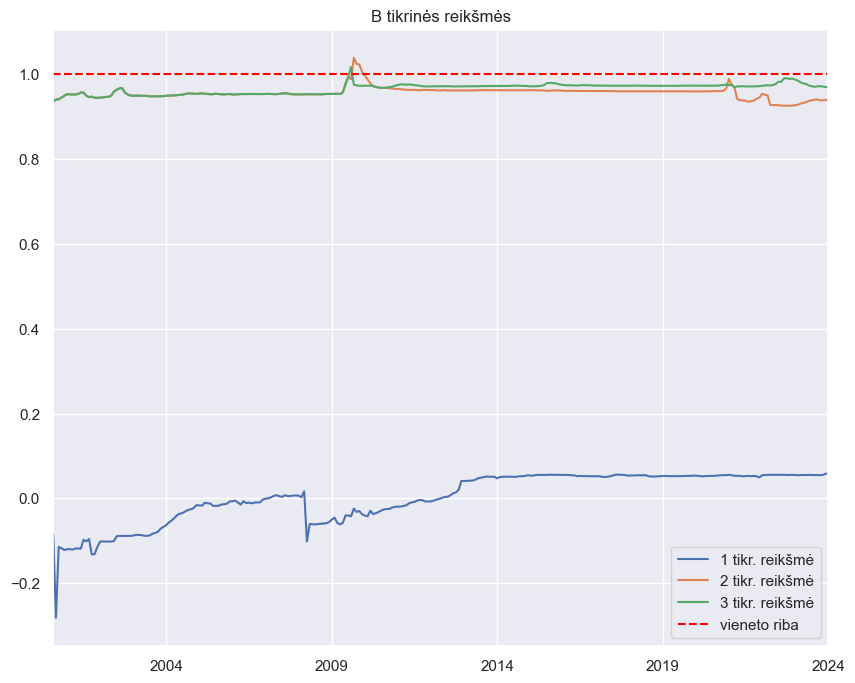

In [24]:
eigens.plot(subplots=False, figsize=(10,8), title=r'B tikrinės reikšmės')
plt.axhline(1, color='red', ls='--')
plt.legend(['1 tikr. reikšmė','2 tikr. reikšmė','3 tikr. reikšmė', 'vieneto riba'])
#plt.axhline(.99)
# plt.axhline(eigens.median().values[0])
# plt.axhline(eigens.median().values[1])
# plt.axhline(eigens.median().values[2])
plt.savefig('nonstateig.png')
plt.show()

In [30]:
data[['g','g1']].corr()

,g,g1
g,1.000000,0.862281
g1,0.862281,1.000000


In [25]:
data = data[data.index >= '2000-08-31'].copy()

In [76]:
data['eg'] = data['g1'] - data['g']

In [31]:
comp_real = data['d'].rolling(N).apply(np.sum).dropna()
comp_pred = (data['g1']*N).shift(N-1).dropna()

<Axes: >

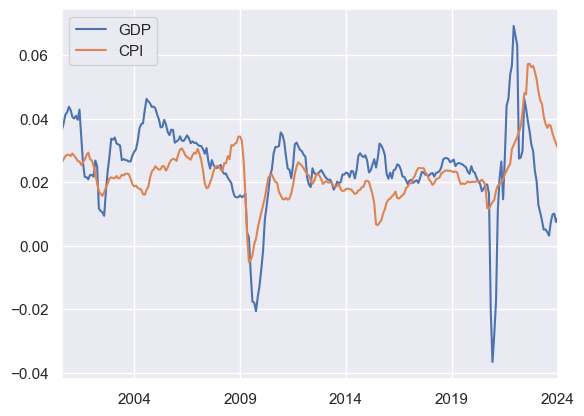

In [32]:
data[['GDP','CPI']].plot()

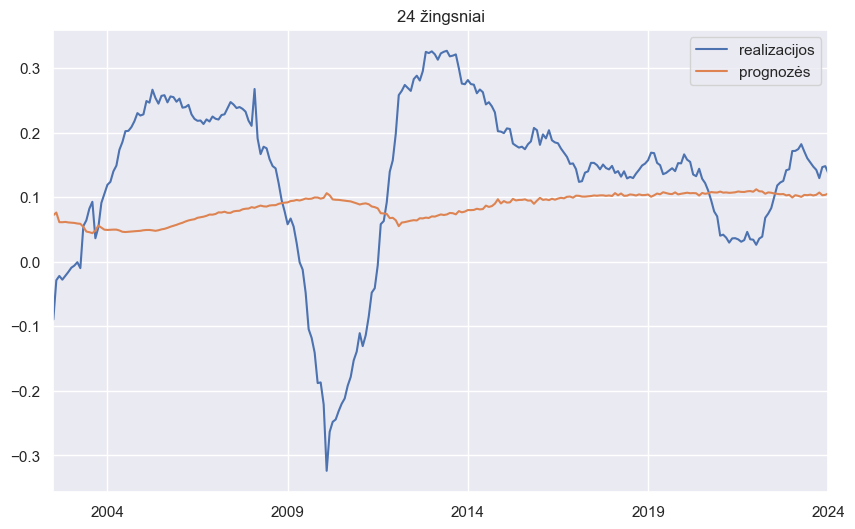

In [33]:
#data[['GDP6','CPI6']].plot()
comp_real.plot(figsize=(10,6))
comp_pred.plot()
# (comp_pred - comp_pred.std()*1.65).plot()
# (comp_pred + comp_pred.std()*1.65).plot()
plt.legend(['realizacijos','prognozės'])
plt.title(f'{N} žingsniai')
#data[['GDP6','CPI6']].loc[comp_real.index].plot()
#(data['g']*N).loc[comp_real.index].plot()
plt.show() # parameter smoothing

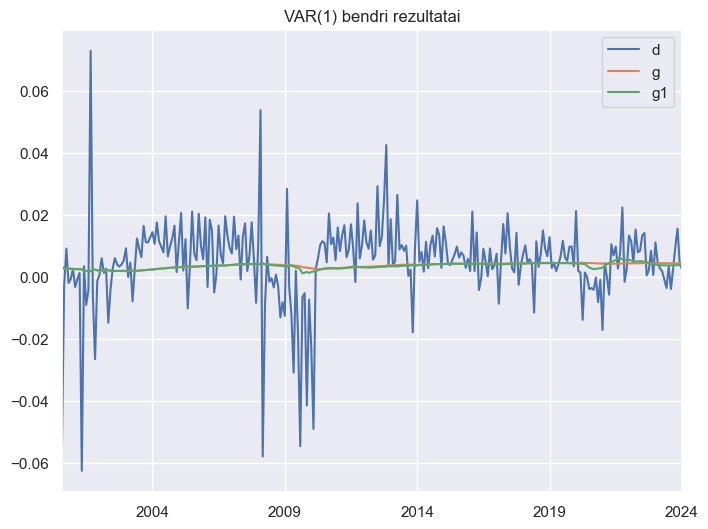

In [93]:
#ax = (data['d'].rolling(12).sum()).plot(title='Long-term dividend growth', figsize=(8,6), ls='--')
(data[['d','g', 'g1']]).plot(title='VAR(1) bendri rezultatai', figsize=(8,6))
plt.savefig('varbendri.png')
plt.show()
#plt.savefig('ltdg.png')

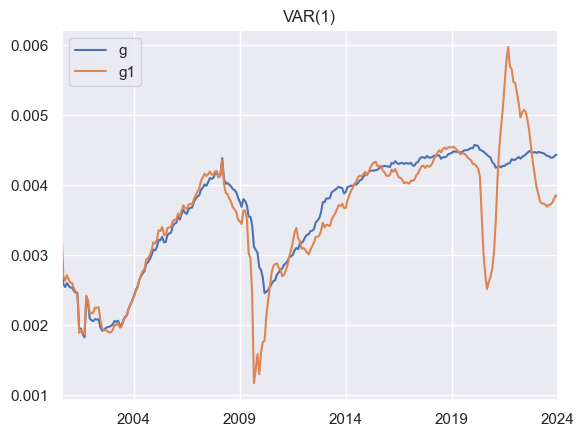

In [94]:
data.plot(y=['g','g1'], title='VAR(1)')
plt.savefig('varcompare.png')

In [26]:
%%time
def func(m,args,N):
    return args['P'] - args['D']*np.exp(args['g1'])/(m - np.exp(args['g1']) + 1) \
    * (1 - (np.exp(args['g1'])/(1 + m))**N) - args['D']*np.exp(args['g'])/(m - args['g'])\
    * (np.exp(args['g1'])/(1 + m))**N

# data["m"] = data["D"]*(1+data["g"])/data["P"] + data["g"]
#data["m"] = data["D"]*(np.exp(data["g1"]))/data["P"] + np.exp(data["g"]) - 1
m = np.zeros(len(data))
for i in range(len(data)):
    solution = fsolve(func, x0=data.iloc[i]['g']*2+0.001, args=(data.iloc[i], N))
    m[i] = solution[0]

data['m'] = m
data["m-g"] = data["m"] - np.exp(data["g"]) + 1

del m

CPU times: total: 109 ms
Wall time: 176 ms


Nustatomas $\eta$ parametras pagal transformuotos dalies kintamumą.

Vertinama pagal:
- $\min|\sigma_{1} - \sigma_{2}|$
- $\min|\frac{\sigma_{1}}{\sigma_{2}} - 1|$

In [27]:
voldiffs = np.zeros(99)
volratios = np.zeros(99)
for pct in range(1,100):
    voldiffs[pct-1] = vol_diff(data['m-g'], pct/100)
    volratios[pct-1] = vol_ratio(data['m-g'], pct/100)

In [28]:
np.argwhere(volratios == np.nanmin(volratios))[0,0], np.argwhere(voldiffs == np.nanmin(voldiffs))[0,0]

(40, 40)

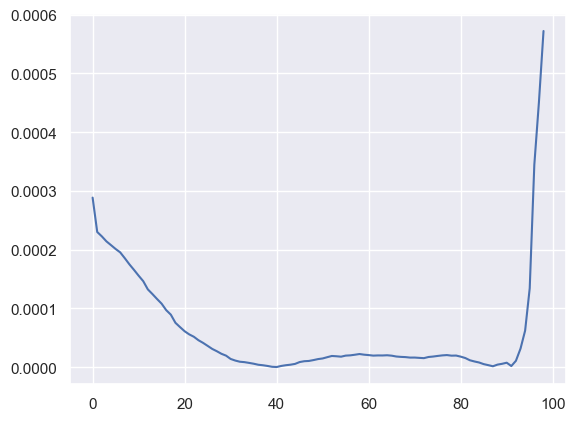

In [29]:
plt.plot(voldiffs)

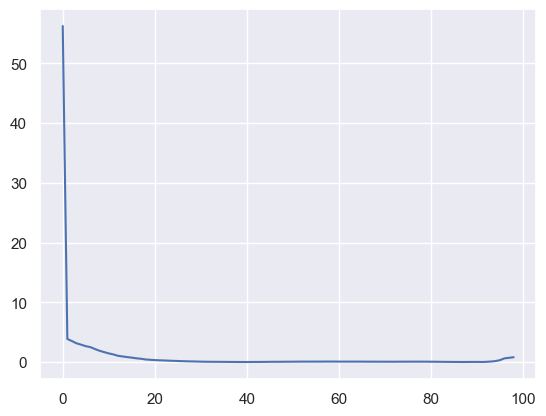

In [30]:
plt.plot(volratios)

In [31]:
kappa = data['m-g'].min()*.8
if np.argwhere(voldiffs == np.nanmin(voldiffs))[0,0] == np.argwhere(volratios == np.nanmin(volratios))[0,0]:
    eta = data['m-g'].quantile((np.argwhere(voldiffs == np.nanmin(voldiffs))[0,0] + 1)/100)
else:
    print("percentiles don't match")

# eta = data['m-g'].quantile(0.25)
data['shadow'] = data['m-g'].apply(inv_call, k=kappa, n=eta)

In [32]:
call_param = pd.DataFrame({'kappa': kappa, 'eta': eta}, index=[0])

In [33]:
call_param

,kappa,eta
0,0.000739,0.001484


Text(0.5, 1.0, 'm-g')

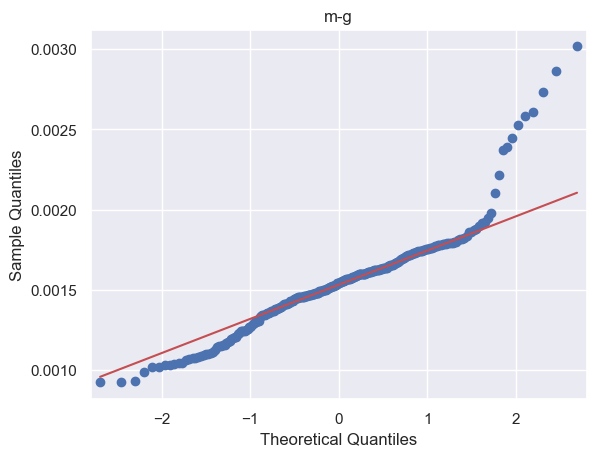

In [34]:
_ = sm.qqplot(data['m-g'], line='q')
plt.title('m-g')

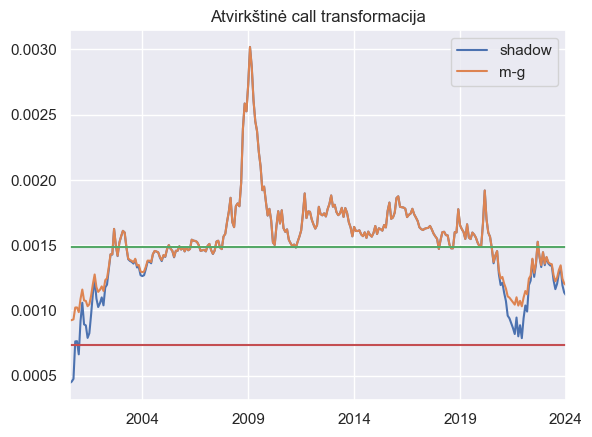

In [35]:
data.plot(y=['shadow','m-g'],
        title='Atvirkštinė call transformacija')
plt.axhline(kappa, color='r')
plt.axhline(eta, color='g')
#plt.savefig('call.png')
plt.show()

Text(0.5, 1.0, 'shadow')

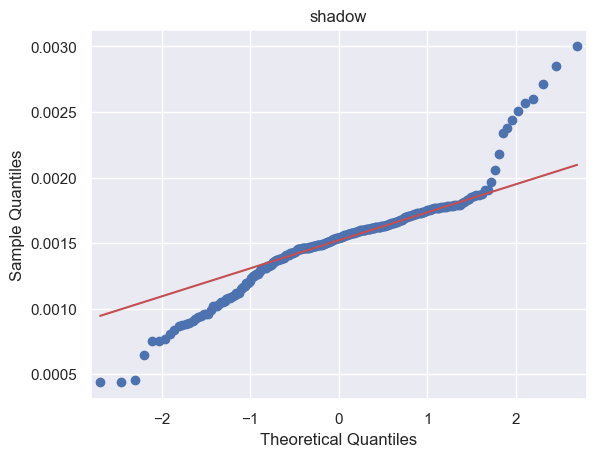

In [87]:
_ = sm.qqplot(data['shadow'], line='q')
plt.title('shadow')

array([[<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >]], dtype=object)

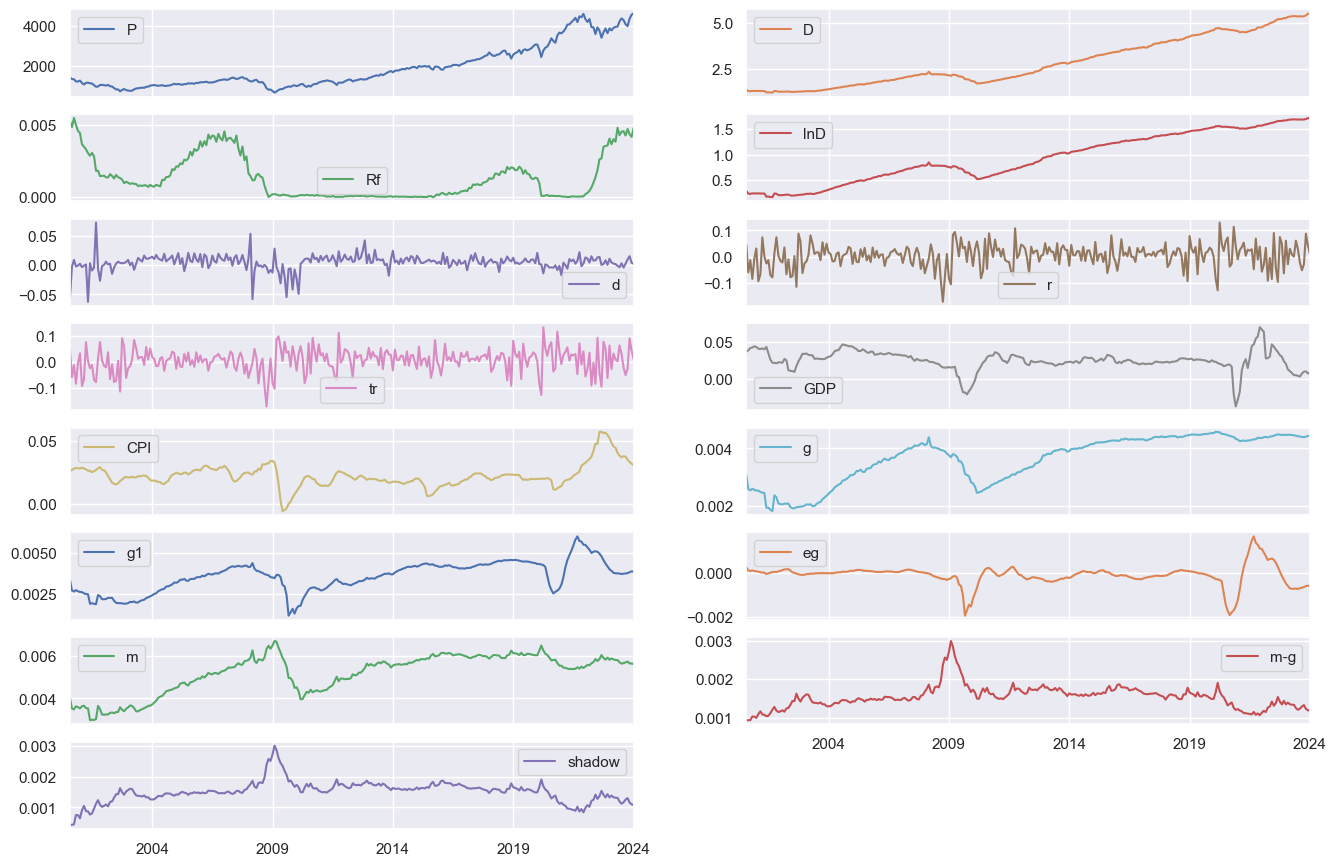

In [785]:
data.plot(subplots=True, figsize=(16,12), layout=(9,2))

# Monte carlo simulations

In [36]:
train_size = 120
horizons = np.array([1, 12, 12*3, 12*5, 12*10]) # array of horizons
eval_size = data.shape[0] - train_size + horizons.max()
lag = 1

eval_dates = pd.date_range(start = data.index[train_size], freq='ME', periods = eval_size)
eval_dates

DatetimeIndex(['2010-08-31', '2010-09-30', '2010-10-31', '2010-11-30',
               '2010-12-31', '2011-01-31', '2011-02-28', '2011-03-31',
               '2011-04-30', '2011-05-31',
               ...
               '2033-04-30', '2033-05-31', '2033-06-30', '2033-07-31',
               '2033-08-31', '2033-09-30', '2033-10-31', '2033-11-30',
               '2033-12-31', '2034-01-31'],
              dtype='datetime64[ns]', length=282, freq='ME')

In [37]:
full_model = VAR(endog=data[['g','shadow','Rf']].iloc[:]).fit(lag)

In [38]:
np.abs(np.linalg.eig(full_model.params[1:].values).eigenvalues)

array([0.99222637, 0.97893845, 0.95875981])

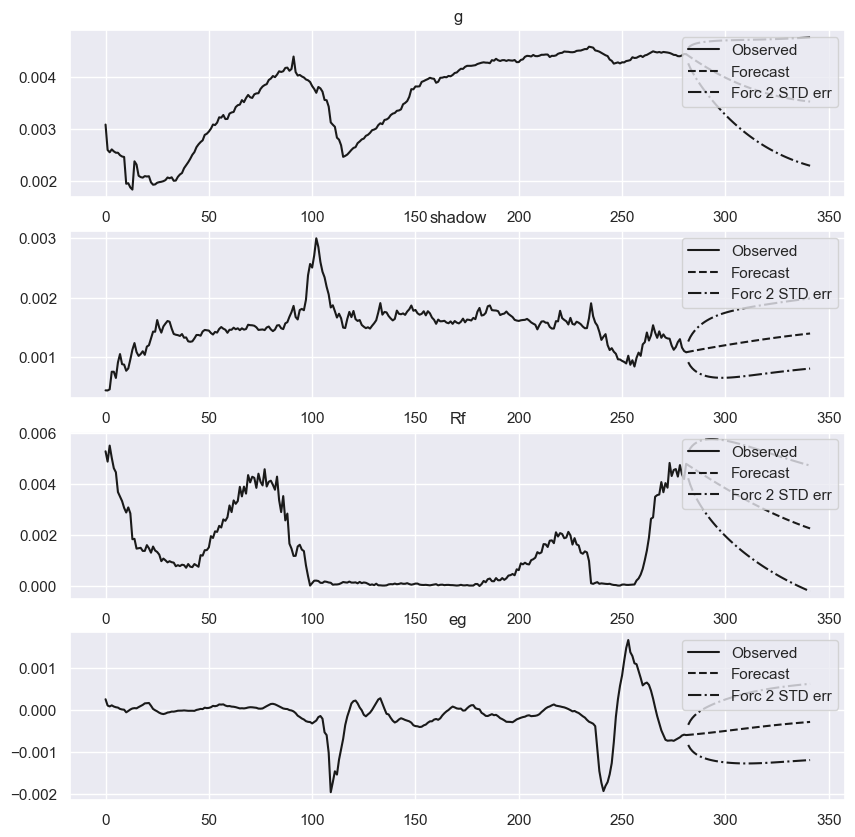

In [789]:
_ = full_model.plot_forecast(60)

In [719]:
full_model.is_stable()

True

In [720]:
np.abs(np.linalg.eig(full_model.params.values[1:]).eigenvalues)

array([0.99222637, 0.97893845, 0.95875981])

In [721]:
full_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 06, May, 2024
Time:                     13:13:27
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -54.1659
Nobs:                     281.000    HQIC:                  -54.2590
Log likelihood:           6447.97    FPE:                2.56197e-24
AIC:                     -54.3213    Det(Omega_mle):     2.45560e-24
--------------------------------------------------------------------
Results for equation g
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.000016         0.000027            0.578           0.563
L1.g              0.996782         0.005327          187.107           0.000
L1.shadow         0.002175         0.013939            0.156           0.876
L1.

In [39]:
sim_number = 10**4
shock_number = eval_size * sim_number

Shocks

Sugeneravus norimus galima pereiti prie **'Simulations'**

In [40]:
# normal shocks
dist = multivariate_normal(mean=[0,0,0], cov = full_model.resid.cov().values, seed=42)
shocks = dist.rvs(size = shock_number)
shocks -= shocks.mean()

In [41]:
shocks

array([[-3.51836607e-05,  3.64745297e-05, -1.26401904e-04],
       [ 1.89095626e-05,  3.64811474e-05, -3.93301551e-04],
       [-3.97566605e-06, -5.12353232e-05, -4.12909626e-04],
       ...,
       [-9.74891755e-05, -1.10028684e-04, -9.51383509e-05],
       [-2.69374821e-05,  1.99813921e-06,  3.74104207e-04],
       [-8.09057434e-05, -3.57646954e-05, -5.40877243e-04]])

In [1034]:
# t shocks
df = 3
dist = multivariate_t(loc=[0,0,0,0], shape = (df-2)/df * full_model.resid.cov(), df=df, seed=42)
shocks = dist.rvs(size = shock_number)
shocks -= shocks.mean()

## Simulations

In [43]:
%%time
#create empty frames for returns
r_frame = [pd.DataFrame()]*len(horizons)
tr_frame = [pd.DataFrame()]*len(horizons)

r_ind_frame = [pd.DataFrame()]*len(horizons)
tr_ind_frame = [pd.DataFrame()]*len(horizons)

# eigs = np.zeros((eval_size-horizons.max(), 4))
# pars = np.zeros((eval_size-horizons.max(), 16))
for i in range(eval_size-horizons.max()):
    start = time.time()
    #print(f"{i} iteration started")
    # creating temporary frames for given dates
    dates = eval_dates[i:(i+horizons.max())]
    # evaluating model
    model = VAR(data[['g','shadow', 'Rf']].values[0:(train_size+i)]).fit(lag)
    # eigs[i] = np.abs(np.linalg.eig(model.params[1:]).eigenvalues)
    # pars[i] = model.params[1:].reshape(1,16)
    r_sim, tr_sim = simulation(data, shocks, model, horizons, kappa, eta, lag, train_size, i, sim_number, eval_size, eval_dates, 0,N)

    #print(r_sim[0])
    # allocating memory to quantile
    r_q = [pd.DataFrame()]*len(horizons)
    tr_q = [pd.DataFrame()]*len(horizons)

    r_ind = [pd.DataFrame()]*len(horizons)
    tr_ind = [pd.DataFrame()]*len(horizons)
    
    for h in range(len(horizons)):

        # calculate quantiles (in the same loop?)
        dict = {f'q{0.99}': np.quantile(r_sim[h], .99, axis=0),
                f'q{0.01}': np.quantile(r_sim[h], .01, axis=0),
                f'q{0.95}': np.quantile(r_sim[h], .95, axis=0),
                f'q{0.05}': np.quantile(r_sim[h], .05, axis=0),
                'median': np.median(r_sim[h], axis=0)}
        r_q[h] = pd.DataFrame(dict, index = [dates[horizons[h]-1]])

        dict = {'VaR': -np.quantile(r_sim[h], .05, axis=0),
                'CVaR': - r_sim[h][r_sim[h] < np.quantile(r_sim[h], .05, axis=0)].mean(),
               'std': r_sim[h].std(),
               'mean':r_sim[h].mean()}
        r_ind[h] = pd.DataFrame(dict, index = [dates[horizons[h]-1]])

        dict = {f'q{0.99}': np.quantile(tr_sim[h], .99, axis=0),
                f'q{0.01}': np.quantile(tr_sim[h], .01, axis=0),
                f'q{0.95}': np.quantile(tr_sim[h], .95, axis=0),
                f'q{0.05}': np.quantile(tr_sim[h], .05, axis=0),
                'median': np.median(tr_sim[h], axis=0)}
        tr_q[h] = pd.DataFrame(dict, index = [dates[horizons[h]-1]])

        dict = {#'VaR': -np.quantile(tr_sim[h], .05, axis=0),
                #'CVaR': -tr_sim[h][tr_sim[h] < np.quantile(tr_sim[h], .05, axis=0)].mean(),
               'std': tr_sim[h].std(),
               'mean': tr_sim[h].mean()}
        tr_ind[h] = pd.DataFrame(dict, index = [dates[horizons[h]-1]])

        r_frame[h] = pd.concat([r_frame[h], r_q[h]], axis=0)
        tr_frame[h] = pd.concat([tr_frame[h], tr_q[h]], axis=0)

        r_ind_frame[h] = pd.concat([r_ind_frame[h], r_ind[h]], axis=0)
        tr_ind_frame[h] = pd.concat([tr_ind_frame[h], tr_ind[h]], axis=0)

    # printing simulation progress
    clear_output(wait=True)
    print(f'{i+1}/{eval_size-horizons.max()} - {(time.time() - start):.3f}')

162/162 - 5.898
CPU times: total: 6min 5s
Wall time: 14min 58s


In [69]:
data[['eg','shadow']].corr()

,eg,shadow
eg,1.000000,-0.259981
shadow,-0.259981,1.000000


<Axes: >

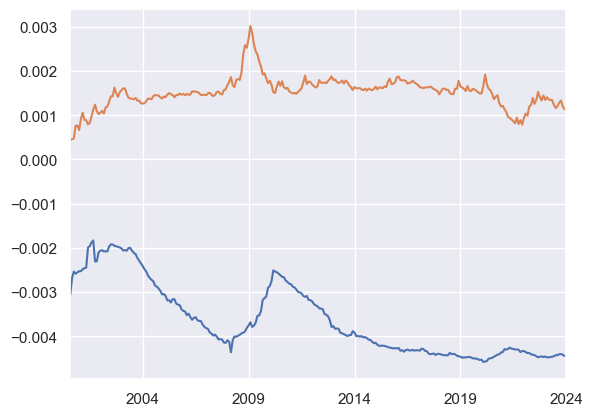

In [51]:
data['eg'].plot()
data['shadow'].plot()

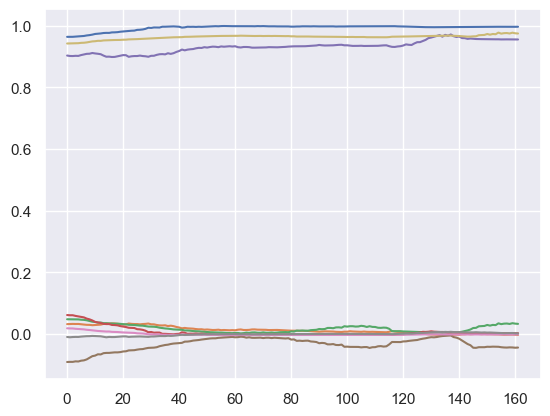

In [52]:
plt.plot(pars);

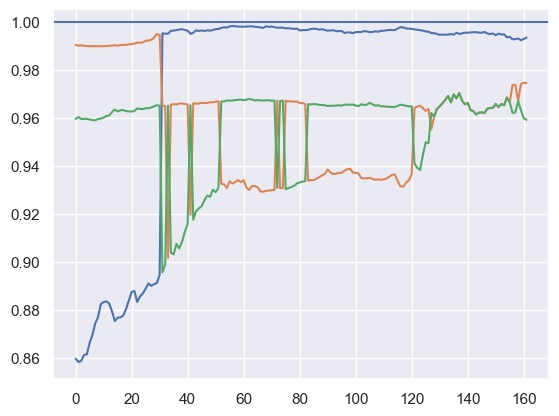

In [53]:
plt.plot(eigs)
plt.axhline(1)

In [77]:
full_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 30, Apr, 2024
Time:                     10:18:06
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -71.9695
Nobs:                     281.000    HQIC:                  -72.1246
Log likelihood:           8573.21    FPE:                4.28158e-32
AIC:                     -72.2284    Det(Omega_mle):     3.98993e-32
--------------------------------------------------------------------
Results for equation g
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const            -0.000001         0.000030           -0.036           0.971
L1.g              0.995964         0.005686          175.170           0.000
L1.shadow         0.017110         0.015622            1.095           0.273
L1.

In [65]:
eigs[133]

array([0.95689111, 0.95689111, 0.96507622, 0.99048143])

In [91]:
1.0000847**60

1.005094718958044

In [65]:
eval_dates[133]

Timestamp('2021-09-30 00:00:00')

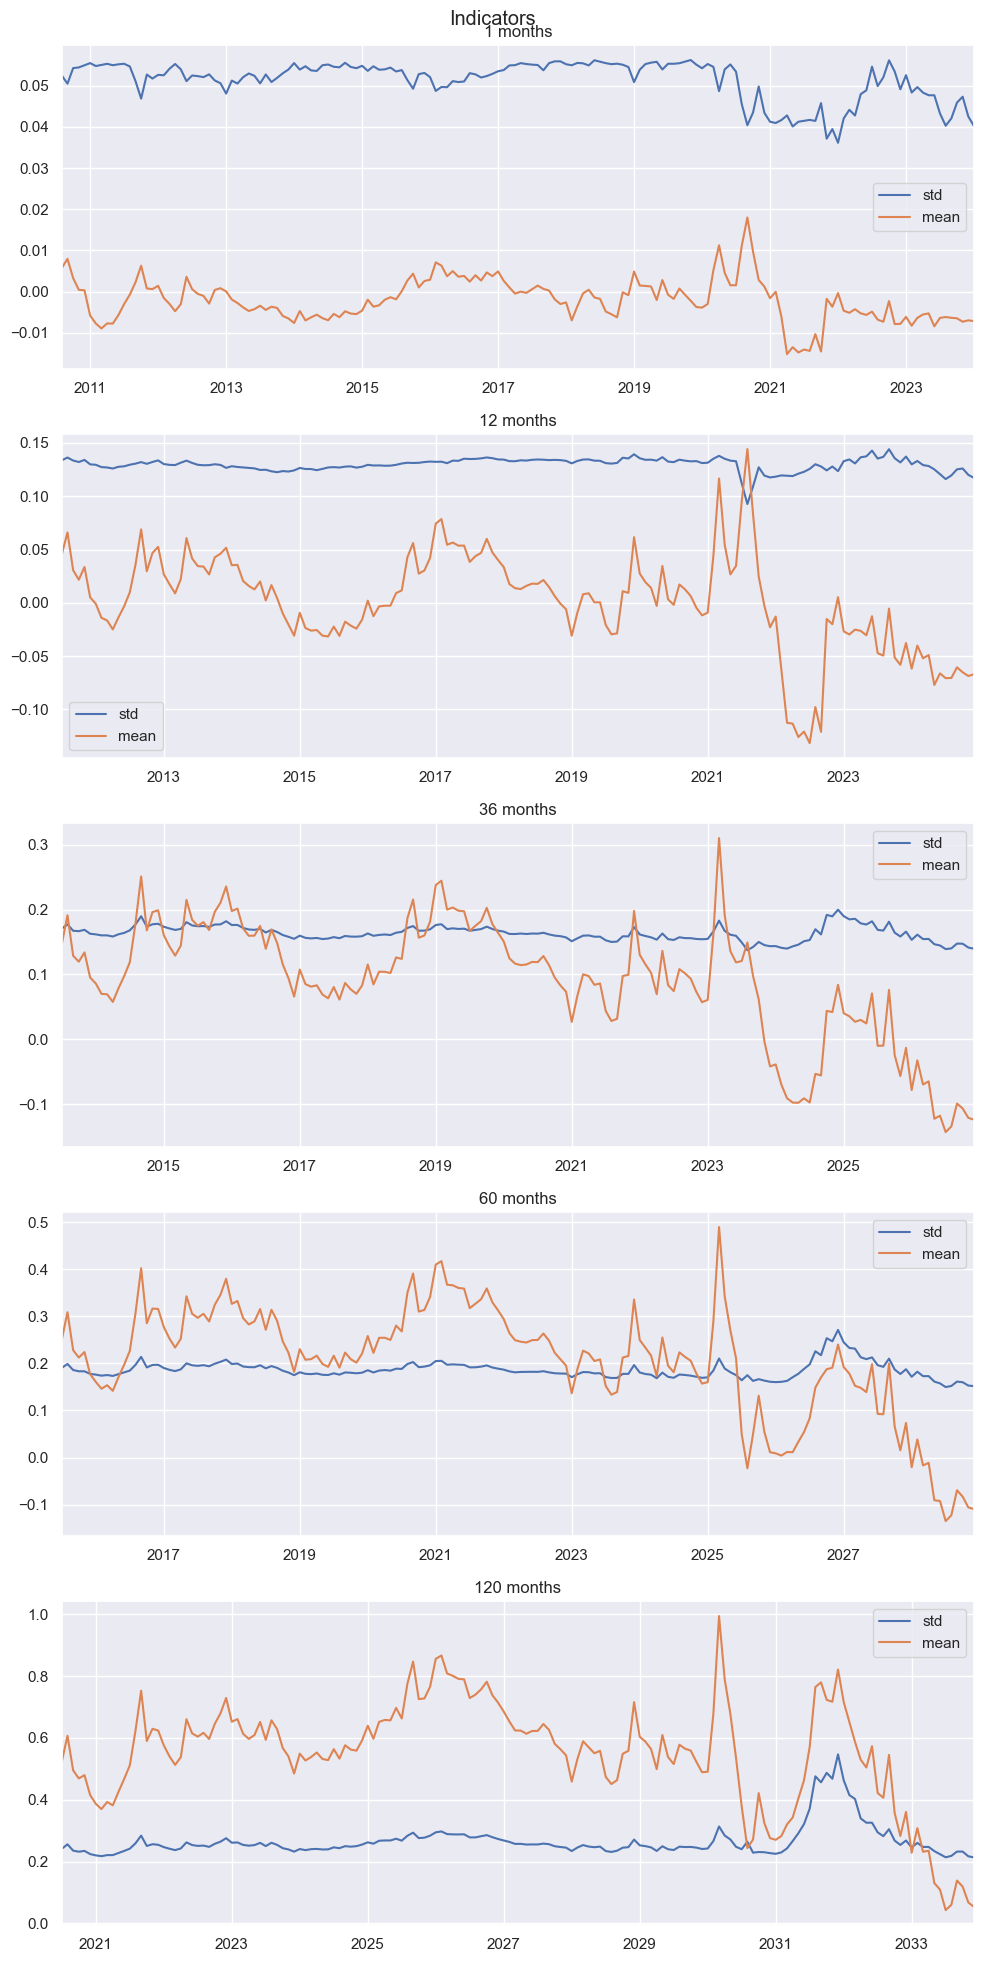

In [93]:
fig, ax = plt.subplots(len(horizons),1, figsize=(10,4*len(horizons)))
for h in range(len(horizons)):
    tr_ind_frame[h].plot(title=f'{horizons[h]} months', ax=ax[h], legend=1)#, ylim=[-.02,.02])

fig.suptitle('Indicators')
plt.tight_layout()
plt.savefig('varindi.png')
plt.show()

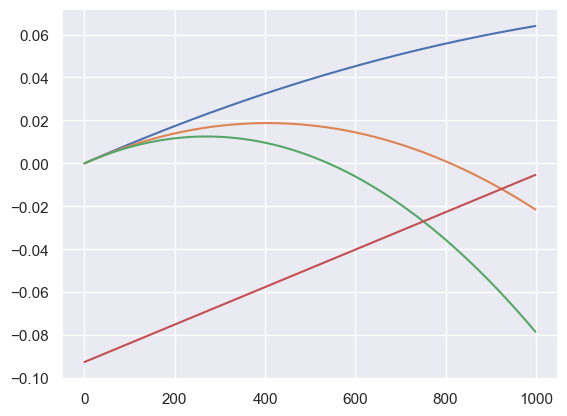

In [102]:
w = np.arange(0,1,0.001)
#10/2 * w**2 * std**2 - w * mean
mean = tr_ind_frame[2].iloc[110]['mean']
std = tr_ind_frame[2].iloc[110]['std']

plt.plot(-2.5/2 * w**2 * std**2 + w * mean)
plt.plot(-10/2 * w**2 * std**2 + w * mean)
plt.plot(-15/2 * w**2 * std**2 + w * mean)
plt.plot(w*std*(12/horizons[2])**.5 - mean)

## Investiciniu svoriu nustatymas su pasirinktu $\lambda$

In [44]:
%%time
lambd = 7
def objective(w, mean, std):
    return lambd/2 * w**2 * std**2 - w * mean

def con(w, L, mean, std):
    #return L - w * std
    return L - norm(0,1).ppf(0.95)*std*w

weights = [np.zeros(tr_ind_frame[h].shape[0]) for h in range(len(horizons))]
for h in range(len(horizons)):
    L = 0.1
    for i in range(tr_ind_frame[h].shape[0]):
        mean = tr_ind_frame[h].iloc[i]['mean']
        std = tr_ind_frame[h].iloc[i]['std']
        #var = tr_ind_frame[h].iloc[i]['VaR']
        constr = [{'type':'ineq', 'fun':con, 'args':(L,mean*(12/horizons[h]),std*(12/horizons[h])**.5)},
                 {'type':'ineq', 'fun':lambda x: x}]
        weights[h][i] = minimize(objective, x0=L/std*(horizons[h]/12)**.5, constraints=constr, args=(mean,std)).x[0]
        clear_output(wait=True)
        print(h, i)
    
    weights[h] = pd.DataFrame(weights[h], columns=['w'], index=eval_dates[:-horizons.max()])

4 161
CPU times: total: 1.06 s
Wall time: 6.98 s


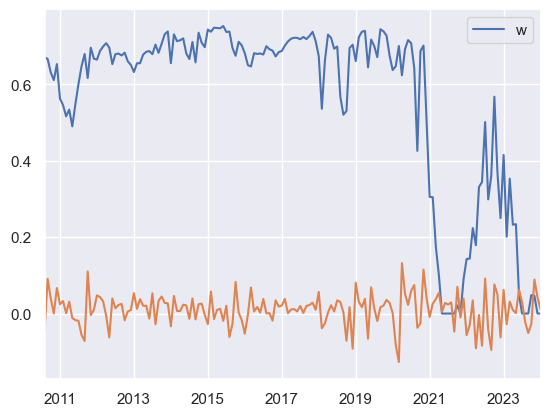

In [125]:
weights[3].plot()
data['tr'].loc[eval_dates[:-horizons.max()]].plot()
plt.show()

In [277]:
# # calculating weights
# RB = np.array([10, 13, 10/1.65]) # risk budget for different indicators
# weights = [pd.DataFrame()]*len(horizons)

# for h in range(len(horizons)):
#     weights[h] = (RB/(100*tr_ind_frame[h][['VaR','CVaR', 'std']])).clip(lower=0)
#     weights[h].index = eval_dates[:-horizons.max()] # shift the weights back

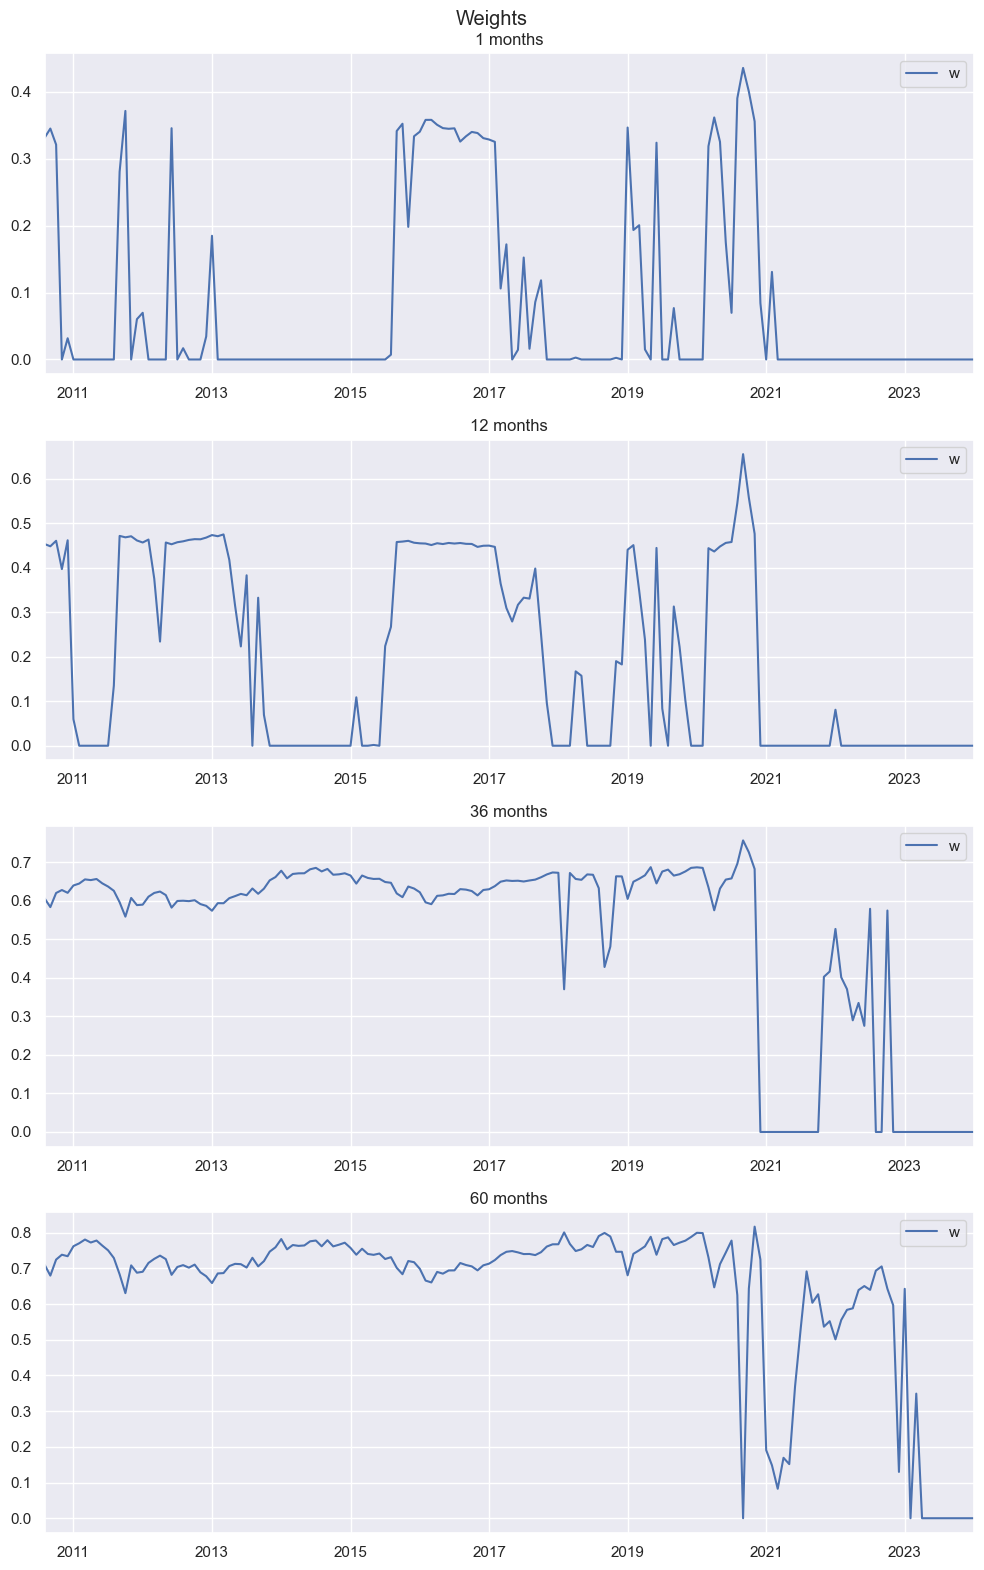

In [68]:
fig, ax = plt.subplots(len(horizons),1, figsize=(10,4*len(horizons)))
for h in range(len(horizons)):
    weights[h].plot(title=f'{horizons[h]} months', ax=ax[h])

fig.suptitle('Weights')
plt.tight_layout()
plt.savefig('weights.png')
plt.show()

In [45]:
real_return = [pd.DataFrame()]*len(horizons)
for h in range(len(horizons)):
    real_return[h] = data["tr"].iloc[train_size:] # not dependant on horizon anymore, probably no need to save multiple

In [46]:
opt_weighted = [pd.DataFrame()]*len(horizons)
for h in range(len(horizons)):
    opt_weighted[h] = real_return[h] * weights[h]['w'].loc[real_return[h].index]

In [143]:
data[['g','shadow','eg','Rf']].describe()

,g,shadow,eg,Rf
count,282.000000,282.000000,282.000000,282.000000
mean,0.003636,0.001512,-0.000098,0.001340
std,0.000820,0.000342,0.000466,0.001496
min,0.001830,0.000437,-0.001947,-0.000008
25%,0.003015,0.001377,-0.000220,0.000078
50%,0.003953,0.001540,-0.000014,0.000840
75%,0.004335,0.001665,0.000072,0.002019
max,0.004579,0.003000,0.001667,0.005502


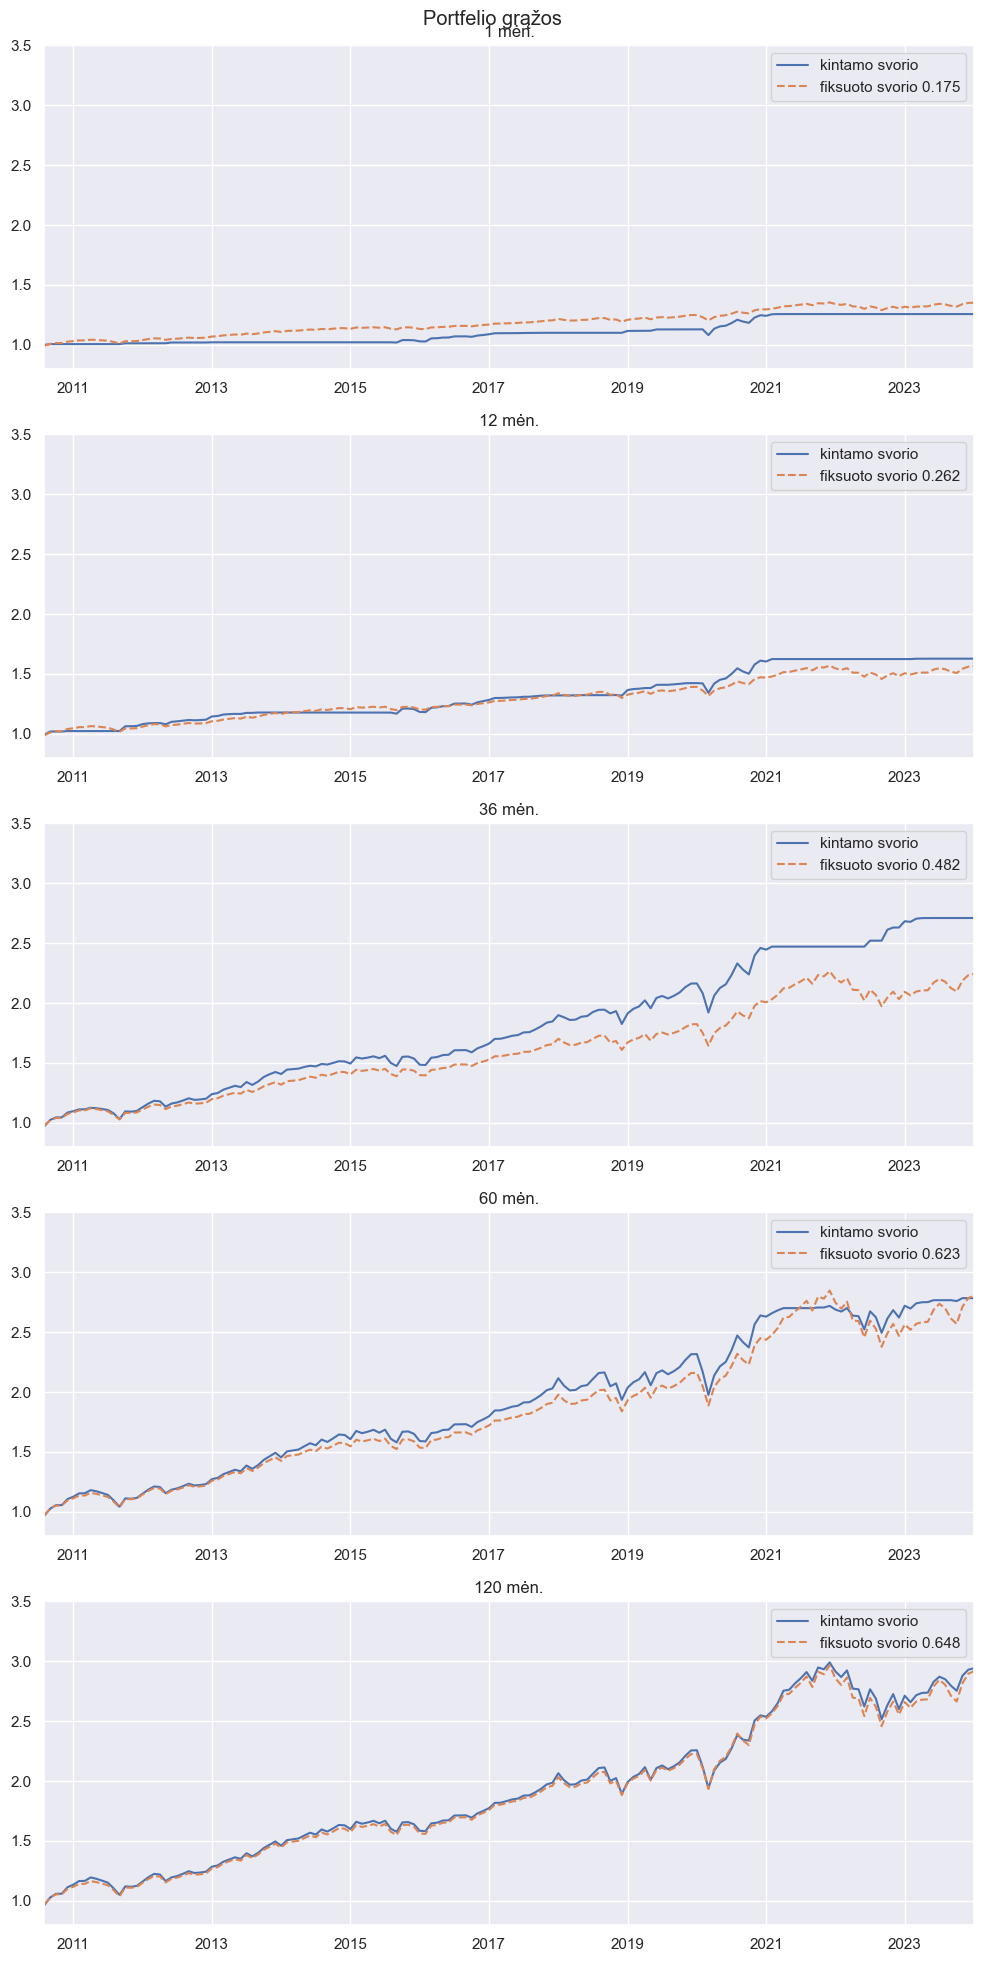

In [97]:
fig, ax = plt.subplots(len(horizons),1, figsize=(10,4*len(horizons)))
for h in range(len(horizons)):
    (1 + opt_weighted[h]).expanding().apply(np.prod).plot(title=f'{horizons[h]} mėn.', ax=ax[h], legend=0, ylim=[.80,3.5])
    fixed = opt_weighted[h].std() / real_return[h].std()
    (1 + fixed * real_return[h]).expanding().apply(np.prod).plot(ls='--', ax=ax[h])
    ax[h].legend(['kintamo svorio',f'fiksuoto svorio {fixed:.3f}'])

fig.suptitle('Portfelio grąžos')
plt.tight_layout()
plt.savefig(f'arportf{lambd}.png')
plt.show()

In [47]:
# calculating indicators for portfolio returns
indicator_frame = pd.DataFrame()
f_indicator_frame = pd.DataFrame()


for h in range(len(horizons)):
    indicators = pd.DataFrame(index=[horizons[h]])
    indicators.index.name = 'h'
    
    indicators["gmean"] = (1 + opt_weighted[h]).prod()**(12/(len(opt_weighted[h]))) - 1
    indicators["std"] = opt_weighted[h].std()*(12)**.5
    indicators["VaR95"] = opt_weighted[h].std()*norm.ppf(.05)
    indicators["CVaR95"] = opt_weighted[h][opt_weighted[h] < indicators["VaR95"].values[0]].mean()
    
    DD = (1 + opt_weighted[h]).expanding().apply(np.prod)/(1 + opt_weighted[h]).expanding().apply(np.prod).cummax() - 1
    indicators["MDD"] = DD.min()
    
    indicators["SR"] = indicators["gmean"]/indicators["std"]


    monthly_sr = ((1 + opt_weighted[h]).prod()**(1/(len(opt_weighted[h]))) - 1) / opt_weighted[h].std()
    gamma3 = skew(opt_weighted[h], bias=True)
    gamma4 = kurtosis(opt_weighted[h], bias=True)
    indicators["PSR"] = norm.cdf(monthly_sr*(len(opt_weighted[h]) - 1)**.5 / (1 - gamma3*monthly_sr + (gamma4 - 1)/4 * monthly_sr**2)**.5)

    indicator_frame = pd.concat([indicator_frame, indicators])

    # fixed weights
    f_indicators = pd.DataFrame(index=[horizons[h]])
    f_indicators.index.name = 'h'
    
    fixed = opt_weighted[h].std() / real_return[h].std()
    f_weighted = fixed * real_return[h]

    f_indicators["gmean"] = (1 + f_weighted).prod()**(12/(len(f_weighted))) - 1
    f_indicators["std"] = f_weighted.std()*(12)**.5
    f_indicators["VaR95"] = f_weighted.std()*norm.ppf(.05)
    f_indicators["CVaR95"] = f_weighted[f_weighted < f_indicators["VaR95"].values[0]].mean()
    
    DD = (1 + f_weighted).expanding().apply(np.prod)/(1 + f_weighted).expanding().apply(np.prod).cummax() - 1
    f_indicators["MDD"] = DD.min()
    
    f_indicators["SR"] = f_indicators["gmean"]/f_indicators["std"]


    monthly_sr = ((1 + f_weighted).prod()**(1/(len(f_weighted))) - 1) / f_weighted.std()
    gamma3 = skew(f_weighted, bias=True)
    gamma4 = kurtosis(f_weighted, bias=True)
    f_indicators["PSR"] = norm.cdf(monthly_sr*(len(f_weighted) - 1)**.5 / (1 - gamma3*monthly_sr + (gamma4 - 1)/4 * monthly_sr**2)**.5)
    f_indicator_frame = pd.concat([f_indicator_frame, f_indicators])

    


indicator_frame

,gmean,std,VaR95,CVaR95,MDD,SR,PSR
h,,,,,,,
1,0.016285,0.026043,-0.012366,-0.022324,-0.029647,0.625314,0.998774
12,0.028545,0.038391,-0.018229,-0.030467,-0.047410,0.743550,0.998838
36,0.077759,0.074388,-0.035322,-0.048979,-0.112355,1.045312,0.999839
60,0.091753,0.098322,-0.046686,-0.060874,-0.154492,0.933192,0.999230
120,0.092298,0.103945,-0.049356,-0.060868,-0.168657,0.887953,0.998505


In [48]:
f_indicator_frame

,gmean,std,VaR95,CVaR95,MDD,SR,PSR
h,,,,,,,
1,0.022771,0.026043,-0.012366,-0.015747,-0.048157,0.874364,0.998876
12,0.033490,0.038391,-0.018229,-0.023213,-0.070580,0.872346,0.998795
36,0.064413,0.074388,-0.035322,-0.044979,-0.134399,0.865906,0.998527
60,0.084671,0.098322,-0.046686,-0.059450,-0.175516,0.861159,0.998320
120,0.089391,0.103945,-0.049356,-0.062850,-0.185021,0.859989,0.998267


In [49]:
print(indicator_frame.to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
 & gmean & std & VaR95 & CVaR95 & MDD & SR & PSR \\
h &  &  &  &  &  &  &  \\
\midrule
1 & 0.016285 & 0.026043 & -0.012366 & -0.022324 & -0.029647 & 0.625314 & 0.998774 \\
12 & 0.028545 & 0.038391 & -0.018229 & -0.030467 & -0.047410 & 0.743550 & 0.998838 \\
36 & 0.077759 & 0.074388 & -0.035322 & -0.048979 & -0.112355 & 1.045312 & 0.999839 \\
60 & 0.091753 & 0.098322 & -0.046686 & -0.060874 & -0.154492 & 0.933192 & 0.999230 \\
120 & 0.092298 & 0.103945 & -0.049356 & -0.060868 & -0.168657 & 0.887953 & 0.998505 \\
\bottomrule
\end{tabular}



In [51]:
print(f_indicator_frame.to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
 & gmean & std & VaR95 & CVaR95 & MDD & SR & PSR \\
h &  &  &  &  &  &  &  \\
\midrule
1 & 0.022771 & 0.026043 & -0.012366 & -0.015747 & -0.048157 & 0.874364 & 0.998876 \\
12 & 0.033490 & 0.038391 & -0.018229 & -0.023213 & -0.070580 & 0.872346 & 0.998795 \\
36 & 0.064413 & 0.074388 & -0.035322 & -0.044979 & -0.134399 & 0.865906 & 0.998527 \\
60 & 0.084671 & 0.098322 & -0.046686 & -0.059450 & -0.175516 & 0.861159 & 0.998320 \\
120 & 0.089391 & 0.103945 & -0.049356 & -0.062850 & -0.185021 & 0.859989 & 0.998267 \\
\bottomrule
\end{tabular}



In [333]:
indicator_frame.to_excel('portfolio_temp.xlsx')

In [334]:
f_indicator_frame.to_excel('portfolio_temp.xlsx')

## Quantiles

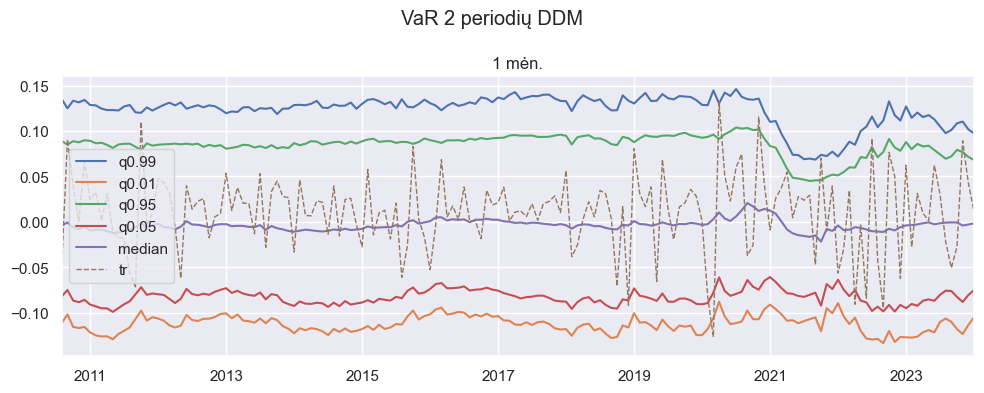

In [277]:
fig, ax = plt.subplots(len(horizons),1, figsize=(10,4*len(horizons)))
for h in range(len(horizons)):
    tr_frame[h].plot(title=f'{horizons[h]} mėn.', ax=ax, legend=0)#, ylim=[-.02,.02])
    #data.loc[data.index.intersection(r_frame[h].index)]["r"].plot(lw=1, ls='--', ax=ax[h])
    comp_prod(data.iloc[train_size:]["tr"], periods=horizons[h]).plot(lw=1, ls='--', ax=ax)

fig.suptitle('VaR 2 periodių DDM')
plt.tight_layout()
plt.legend()
plt.savefig(f'quantplotsvar.png')
plt.show()

In [135]:
# saving quantile frames
for i in range(len(horizons)):
    #r_frame[i].to_excel(f'r{horizons[i]}_sim{sim_number}_dof{df}.xlsx')
    tr_frame[i].to_excel(f'var1.xlsx')

In [327]:
# saving return data
for h in range(len(horizons)):
    #comp_prod(data.iloc[train_size:]["r"], periods=horizons[h]).to_excel(f'data_r{horizons[h]}.xlsx')
    comp_prod(data.iloc[train_size:]["tr"], periods=horizons[h]).to_excel(f'actualtr.xlsx')

In [138]:
print(pd.read_excel("backtestresults.xlsx", sheet_name="garchres", index_col=[0]).to_latex())

print(pd.read_excel("backtestresults.xlsx", sheet_name="arres", index_col=[0]).to_latex())

print(pd.read_excel("backtestresults.xlsx", sheet_name="varres", index_col=[0]).to_latex())

\begin{tabular}{llrllllllll}
\toprule
 & VaRID & VaRLevel & TL & Bin & POF & TUFF & CC & CCI & TBF & TBFI \\
PortfolioID &  &  &  &  &  &  &  &  &  &  \\
\midrule
MSCI & GARCH95 & 0.950000 & 'green' & 'accept' & 'accept' & 'accept' & 'accept' & 'accept' & 'reject' & 'reject' \\
MSCI & GARCH99 & 0.990000 & 'yellow' & 'accept' & 'accept' & 'accept' & 'accept' & 'accept' & 'reject' & 'reject' \\
\bottomrule
\end{tabular}

\begin{tabular}{llrllllllll}
\toprule
 & VaRID & VaRLevel & TL & Bin & POF & TUFF & CC & CCI & TBF & TBFI \\
PortfolioID &  &  &  &  &  &  &  &  &  &  \\
\midrule
MSCI & AR95 & 0.950000 & 'green' & 'accept' & 'accept' & 'reject' & 'accept' & 'accept' & 'accept' & 'accept' \\
MSCI & AR99 & 0.990000 & 'green' & 'accept' & 'accept' & 'accept' & 'accept' & 'accept' & 'accept' & 'accept' \\
\bottomrule
\end{tabular}

\begin{tabular}{llrllllllll}
\toprule
 & VaRID & VaRLevel & TL & Bin & POF & TUFF & CC & CCI & TBF & TBFI \\
PortfolioID &  &  &  &  &  &  &  &  &  &  \\
\midrul

In [1236]:
# loading saved frames
r_frame = [pd.DataFrame()]*len(horizons)
tr_frame = [pd.DataFrame()]*len(horizons)
for i in range(len(horizons)):
    r_frame[i] = pd.read_excel(f'r{horizons[i]}_sim{sim_number}.xlsx', index_col=[0])
    tr_frame[i] = pd.read_excel(f'tr{horizons[i]}_sim{sim_number}.xlsx', index_col=[0])

# RW-GARCH

In [119]:
data['ltr'] = np.log(data['tr'] + 1)

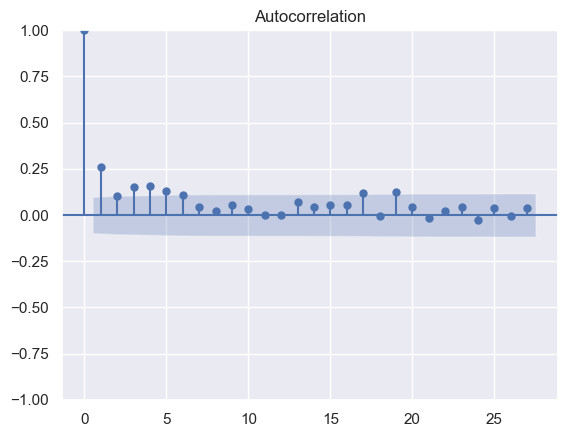

In [123]:
_ = plot_acf(data["ltr"]**2)
plt.savefig('r2acf.png')

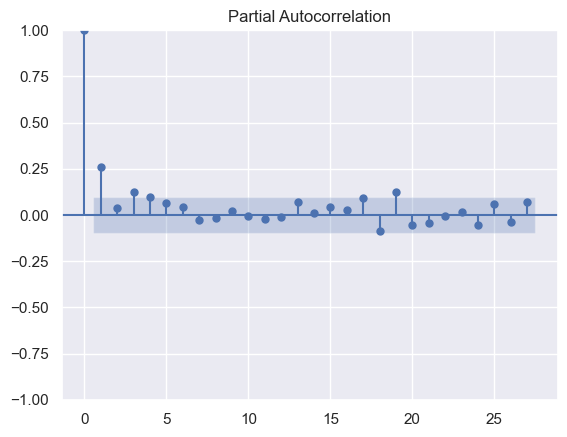

In [124]:
_ = plot_pacf(data["ltr"]**2)
plt.savefig('r2pacf.png')

In [512]:
# data = data[data.index >= '2000-08-31'].copy()

In [663]:
train_size = 240
#horizons = np.array([1,3]) # array of horizons
horizon = 12*10
eval_size = data.shape[0] - train_size + horizon

eval_dates = pd.date_range(start = data.index[train_size], freq='ME', periods = eval_size)
eval_dates

DatetimeIndex(['2010-08-31', '2010-09-30', '2010-10-31', '2010-11-30',
               '2010-12-31', '2011-01-31', '2011-02-28', '2011-03-31',
               '2011-04-30', '2011-05-31',
               ...
               '2033-04-30', '2033-05-31', '2033-06-30', '2033-07-31',
               '2033-08-31', '2033-09-30', '2033-10-31', '2033-11-30',
               '2033-12-31', '2034-01-31'],
              dtype='datetime64[ns]', length=282, freq='ME')

In [664]:
%%time
var95 = np.zeros(eval_size-horizon)
var99 = np.zeros(eval_size-horizon)
np.random.RandomState(42)
r_ind_frame = pd.DataFrame()

paramsums = np.zeros(eval_size-horizon)
for i in range(eval_size-horizon):
    start = time.time()

    dates = eval_dates[i:(i+horizon)]
    # define model/forecast
    am = arch.arch_model(data["ltr"].iloc[0:train_size+i], mean="Constant", vol="GARCH", p=1, q=1, dist="normal", rescale=True)
    res = am.fit(disp='off')
    paramsums[i] = res.params['alpha[1]'] + res.params['beta[1]']
    # simulation fcst
    fc = res.forecast(horizon=horizon, method='simulation', simulations=10000)

    # analytic fcst
    # fc = res.forecast(horizon=horizon)
    
    # return cumulative product
    #var = (1 + fc.variance.values[0] / am.scale**2).prod() - 1 # variance converted to original scale
    #rets = pd.Series(((1 + (fc.simulations.residuals[0]) / am.scale)).prod(axis=1) - 1)
    # simulation stuff
    rets = np.exp((fc.mean.values[0] + fc.simulations.residuals[0].copy())/am.scale).prod(axis=1) - 1
    #rets = np.exp((fc.simulations.residuals[0].copy())/am.scale).prod(axis=1) - 1

    # rets = fc.variance.values[0]**.5 
    
    #plt.hist(rets)
    # value at risk
    # var95[i] = rets.quantile(.05)
    # var99[i] = rets.quantile(.01)
    # get simulation quantiles
    # var95[i] = np.quantile(rets, .05)
    # var99[i] = np.quantile(rets, .01)

    # get analytic quantiles
    var95[i] = np.quantile(rets, .05)
    var99[i] = np.quantile(rets, .01)
    # calculate indicators
    dict = {#'VaR': -np.quantile(rets, .05),
            #'CVaR': -rets[rets < np.quantile(rets, .05)].mean(),
           'std': rets.std(),
           #'mean': np.exp(np.log(1 + rets).mean())-1}
            'mean':rets.mean()}
    #print(rets.std())
    if rets.std() > 5:
        paths = (fc.simulations.residuals[0]/am.scale).T.copy()
    r_ind = pd.DataFrame(dict, index = [dates[horizon-1]])
    r_ind_frame = pd.concat([r_ind_frame, r_ind], axis=0)
    del rets, am, res, fc

    # progress printing
    clear_output(wait=True)
    print(f'{i+1}/{eval_size-horizon} - {(time.time() - start):.3f}')

162/162 - 0.159
CPU times: total: 11.2 s
Wall time: 22.9 s


In [665]:
all([paramsum < 1 for paramsum in paramsums])

True

## Investiciniai svoriai GARCH

In [671]:
# # calculating weights
# RB = np.array([10, 13, 10/1.65]) # risk budget for different indicators
lambd = 10
# weights = (RB/(100*r_ind_frame))
# weights.index = eval_dates[:-horizon]
def objective(w, mean, std):
    return lambd/2 * w**2 * std**2 - w * mean

def con(w, L, mean, std):
    #return L - w * std
    return L - norm(0,1).ppf(0.95)*std*w

weights = np.zeros(r_ind_frame.shape[0])
L = 0.1
for i in range(r_ind_frame.shape[0]):
    mean = r_ind_frame.iloc[i]['mean']
    std = r_ind_frame.iloc[i]['std']
    constr = [{'type':'ineq', 'fun':con, 'args':(L,mean*(12/horizon),std*(12/horizon)**.5)},
             {'type':'ineq', 'fun':lambda x: x}]
    weights[i] = minimize(objective, x0=L/std*(horizon/12)**.5, constraints=constr, args=(mean,std)).x[0]
    clear_output(wait=True)
    print(i)

weights = pd.DataFrame(weights, columns=['w'], index=eval_dates[:-horizon])

161


<Axes: title={'center': 'svoriai - 120 mėn.'}>

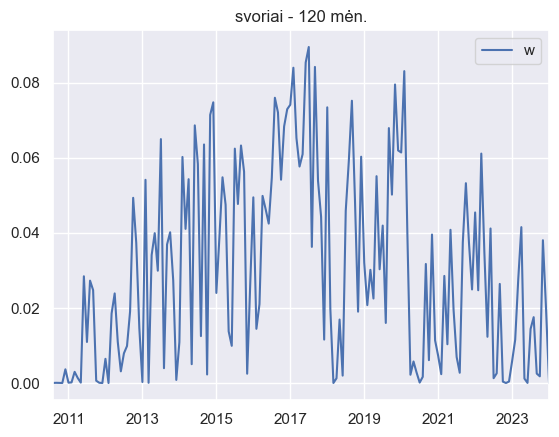

In [672]:
weights.plot(title=f'svoriai - {horizon} mėn.')

<Axes: >

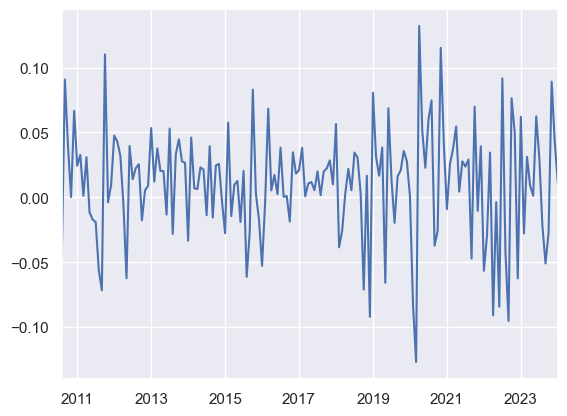

In [673]:
real_return = data["tr"].iloc[train_size:]
real_return.plot()

<Axes: >

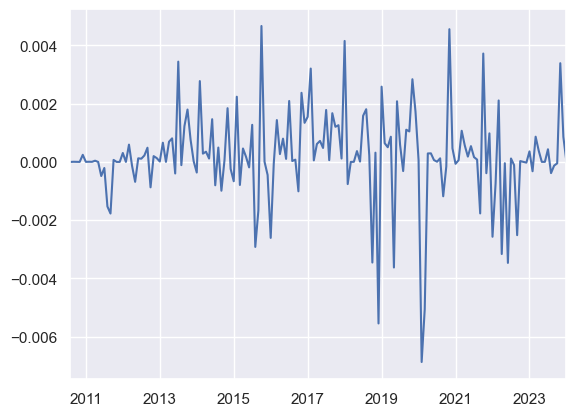

In [674]:
opt_weighted = real_return * weights['w'].loc[real_return.index]
opt_weighted.plot()

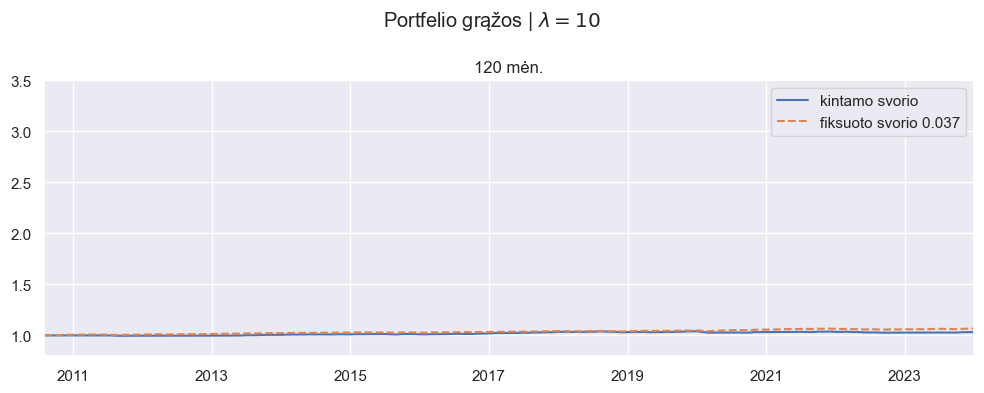

In [675]:
(1 + opt_weighted).expanding().apply(np.prod).plot(title=f'{horizon} mėn.', legend=0, figsize=(10,4), ylim=[0.8, 3.5])
fixed = opt_weighted.std() / real_return.std()
(1 + fixed * real_return).expanding().apply(np.prod).plot(ls='--')
plt.legend(['kintamo svorio',f'fiksuoto svorio {fixed:.3f}'])

plt.suptitle(rf'Portfelio grąžos | $\lambda = {lambd}$')
plt.tight_layout()
plt.savefig(f'pgarch{horizon}lamb{lambd}.png')
plt.show()

In [676]:
# calculating indicators for portfolio returns
indicator_frame = pd.DataFrame()
f_indicator_frame = pd.DataFrame()

indicators = pd.DataFrame(index=[horizon])
indicators.index.name = 'h'

indicators["gmean"] = (1 + opt_weighted).prod()**(12/(len(opt_weighted))) - 1
indicators["std"] = opt_weighted.std()*(12)**.5
indicators["VaR95"] = opt_weighted.std()*norm.ppf(.05)
indicators["CVaR95"] = opt_weighted[opt_weighted < indicators["VaR95"].values[0]].mean()

DD = (1 + opt_weighted).expanding().apply(np.prod)/(1 + opt_weighted).expanding().apply(np.prod).cummax() - 1
indicators["MDD"] = DD.min()

indicators["SR"] = indicators["gmean"]/indicators["std"]


monthly_sr = ((1 + opt_weighted).prod()**(1/(len(opt_weighted))) - 1) / opt_weighted.std()
gamma3 = skew(opt_weighted, bias=True)
gamma4 = kurtosis(opt_weighted, bias=True)
indicators["PSR"] = norm.cdf(monthly_sr*(len(opt_weighted) - 1)**.5 / (1 - gamma3*monthly_sr + (gamma4 - 1)/4 * monthly_sr**2)**.5)

indicator_frame = pd.concat([indicator_frame, indicators])

# fixed weights
f_indicators = pd.DataFrame(index=[horizon])
f_indicators.index.name = 'h'

fixed = opt_weighted.std() / real_return.std()
f_weighted = fixed * real_return

f_indicators["gmean"] = (1 + f_weighted).prod()**(12/(len(f_weighted))) - 1
f_indicators["std"] = f_weighted.std()*(12)**.5
f_indicators["VaR95"] = f_weighted.std()*norm.ppf(.05)
f_indicators["CVaR95"] = f_weighted[f_weighted < f_indicators["VaR95"].values[0]].mean()

DD = (1 + f_weighted).expanding().apply(np.prod)/(1 + f_weighted).expanding().apply(np.prod).cummax() - 1
f_indicators["MDD"] = DD.min()

f_indicators["SR"] = f_indicators["gmean"]/f_indicators["std"]


monthly_sr = ((1 + f_weighted).prod()**(1/(len(f_weighted))) - 1) / f_weighted.std()
gamma3 = skew(f_weighted, bias=True)
gamma4 = kurtosis(f_weighted, bias=True)
f_indicators["PSR"] = norm.cdf(monthly_sr*(len(f_weighted) - 1)**.5 / (1 - gamma3*monthly_sr + (gamma4 - 1)/4 * monthly_sr**2)**.5)
f_indicator_frame = pd.concat([f_indicator_frame, f_indicators])

    


indicator_frame

,gmean,std,VaR95,CVaR95,MDD,SR,PSR
h,,,,,,,
120,0.00236,0.005445,-0.002586,-0.004081,-0.012705,0.43332,0.933355


In [677]:
f_indicator_frame

,gmean,std,VaR95,CVaR95,MDD,SR,PSR
h,,,,,,,
120,0.004778,0.005445,-0.002586,-0.003292,-0.010164,0.877518,0.999


In [678]:
print(indicator_frame.to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
 & gmean & std & VaR95 & CVaR95 & MDD & SR & PSR \\
h &  &  &  &  &  &  &  \\
\midrule
120 & 0.002360 & 0.005445 & -0.002586 & -0.004081 & -0.012705 & 0.433320 & 0.933355 \\
\bottomrule
\end{tabular}



In [679]:
print(f_indicator_frame.to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
 & gmean & std & VaR95 & CVaR95 & MDD & SR & PSR \\
h &  &  &  &  &  &  &  \\
\midrule
120 & 0.004778 & 0.005445 & -0.002586 & -0.003292 & -0.010164 & 0.877518 & 0.999000 \\
\bottomrule
\end{tabular}



In [644]:
indicator_frame.to_excel('portfolio_temp.xlsx')

In [645]:
f_indicator_frame.to_excel('portfolio_temp.xlsx')

In [81]:
dict = {'VaR95': var95, 'VaR99': var99}
vars = pd.DataFrame(dict)
vars.shape

(162, 2)

In [228]:
vars

,VaR95,VaR99
0,-0.085474,-0.121760
1,-0.084670,-0.120037
2,-0.094480,-0.134852
3,-0.088852,-0.124189
4,-0.078583,-0.110319
...,...,...
157,-0.057377,-0.083653
158,-0.063740,-0.092998
159,-0.061270,-0.088782
160,-0.076096,-0.104962


In [83]:
comp_real = comp_prod(data["tr"].iloc[train_size:], periods=horizon).reset_index(drop=True)

In [84]:
#vars = pd.concat([((1 + data["r"].iloc[train_size-horizon:]).rolling(horizon).apply(np.prod) - 1).dropna().reset_index()['r'], vars], axis=1)
vars = pd.concat([comp_real, vars], axis=1)
vars.index = eval_dates[horizon:]

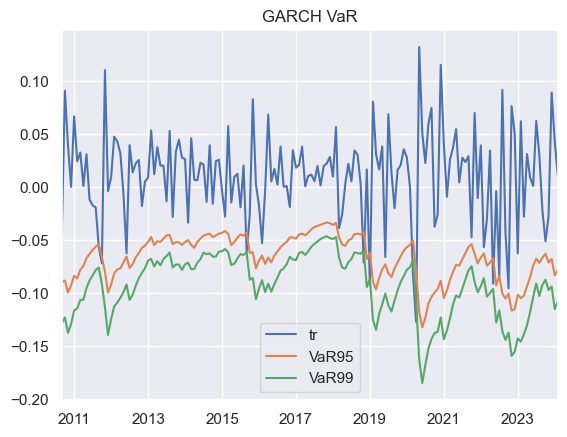

In [85]:
vars.plot(title=f'GARCH VaR')
plt.savefig(f'garchrisk.png')

In [86]:
vars.to_excel(f'garch.xlsx')